## Import library

In [1]:
!pip install psycopg2-binary --user

In [2]:
!pip install python-dotenv

In [3]:
!pip install psutil

In [4]:
!pip install joblib

In [5]:
!pip install fuzzywuzzy python-Levenshtein

In [6]:
!pip install pyspark

In [7]:
import csv
import functools
import time
import random
import warnings

from pyspark.sql import SparkSession, Row, Window
from pyspark.sql.functions import col, count, when, isnan, expr, regexp_extract, regexp_replace, countDistinct, monotonically_increasing_id, row_number
from pyspark.sql.types import StringType, StructType, StructField
from datetime import date, datetime
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import multiprocessing
import time
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import config  # Import the config module
from sqlalchemy import create_engine

from fuzzywuzzy import process

#ETL Util Classes
from etl_util.data_cleaner_util import DataCleanerUtil
from etl_util.data_transform_util import DataTransformUtil
from etl_util.data_load_util import DataLoadUtil

# Guided Project: Building Fast Queries, Cleaning/Transformation, and Analyzing Laptop Prices

This is a guided project from [Dataquest]('https://app.dataquest.io/l') that was further expanded to explore Data Engineering libraries and resources. 

In this project, we will build functions that can do a fast-query on the csv file. The `.csv` file only contains *1,300* copies but in this project. We will assume that the Inventory will contain millions of copies so it is imperative to make the query as efficient and fast as possible.

Furthermore, we have added Data Cleaning/Transformation using PySpark and some analyzing task using SQL Windows function. The project texts can be a litle-bit of verbose as when I made this Project, I mostly move away from the Original instructions from Dataquest and have my own implementation. I explored  the tools/libraries that can efficiently process the dataset as I make this notebook. In short, this notebook is usually a exploratory project detailing the libraries that I found and how I implement it in the laptops dataset. 

If there are any suggestions or corrections in here, please free to create an Git issue in this repository. 

## Overview

*Dataquest* and *Expanded* will have different .csv file as *Dataquest* provided a cleaned .csv file. While for the sake of learning, we will download the .csv file from [kaggle]('https://www.kaggle.com/datasets/muhammetvarl/laptop-price') in-order to start with an unmodified dataset. We will use this on our *Expanded* sub-tasks

The Notebook will be divided into four parts: 

1. Fast Queries (Dataquest): 
    - Create a `Inventory` class containing query method that is efficient in Time Complexity
    - Visualize Time Execution using matplotlib 
    - Uses `laptops_dqds.csv` 
2. PySpark Data Cleaning/Transformation (Expanded):  
    - Uses `laptops_original.csv`
    - Clean the Data
    - Load data to Postgres
4. Analysis using SQL Windows Function (Expanded):
    - Focus on using Windows Function 

## Table Definition



| Id      | Company | Product      | TypeName  | Inches | ScreenResolution            | Cpu                         | Ram | Memory          | Gpu                          | OpSys  | Weight | Price |
|---------|---------|--------------|-----------|--------|-----------------------------|-----------------------------|-----|-----------------|------------------------------|--------|--------|-------|
| 6571244 | Apple   | MacBook Pro  | Ultrabook | 13.3   | IPS Panel Retina Display... | Intel Core i5 2.3GHz        | 8GB | 128GB SSD       | Intel Iris Plus Graphics... | macOS  | 1.37kg | 1339  |
| 7287764 | Apple   | Macbook Air  | Ultrabook | 13.3   | 1440x900                    | Intel Core i5 1.8GHz        | 8GB | 128GB Flash Storage | Intel HD Graphics 6000       | macOS  | 1.34kg | 898   |
| 3362737 | HP      | 250 G6       | Notebook  | 15.6   | Full HD 1920x1080           | Intel Core i5 7200U 2.5GHz  | 8GB | 256GB SSD       | Intel HD Graphics 620        | No OS  | 1.86kg | 575   |
| 9722156 | Apple   | MacBook Pro  | Ultrabook | 15.4   | IPS Panel Retina Display... | Intel Core i7 2.7GHz        | 16GB| 512GB SSD       | AMD Radeon Pro 455           | macOS  | 1.83kg | 2537  |
| 8550527 | Apple   | MacBook Pro  | Ultrabook | 13.3   | IPS Panel Retina Display... | Intel Core i5 3.1GHz        | 8GB | 256GB SSD       | Intel Iris Plus Graphics...  | macOS  | 1.37kg | 1803  |


- **ID:** A unique identifier for the laptop.
- **Company:** The name of the company that produces the laptop.
- **Product:** The name of the laptop.
- **TypeName:** The type of laptop.
- **Inches:** The size of the screen in inches.
- **ScreenResolution:** The resolution of the screen.
- **CPU:** The laptop CPU.
- **RAM:** The amount of RAM in the laptop.
- **Memory:** The size of the hard drive.
- **GPU:** The graphics card name.
- **OpSys:** The name of the operating system.
- **Weight:** The laptop weight.
- **Price:** The price of the laptop.


# Fast Queries (Dataquest)

This section will use the `laptops_dqds.csv` which is the provided .csv file of the Guided Project. This .csv is already clean and contains the proper-type for each columns

## Creating the Class

We will create a class that can efficiently query the laptop Inventory contaiend on the csv file. This `Inventory` class will contain but not limited to: 

1. Find the laptop by Id.
2. Given an price, find two laptops whose total price is same with the given amount.
3. Find laptops whose price falls within a given budget.

Note: 

For the purpose of this Notebook Project, @deprecrated methods are not removed as they will be used for the Performance Analysis segment of this Notebook. 

### Inventory Class Definition

In [8]:
def row_price(item):
    return int(item[1][-1])

class Inventory:
    def __init__(self, csv_filename):
        self.indexed_row = {}
        self.unique_prices = set()
        self.rows_by_price = []
        self.linear_rows = []
        
        with open(csv_filename, newline='') as csvfile:
            csvreader = csv.reader(csvfile)
            self.header = next(csvreader)
            self.linear_rows = list(csvreader)  # Read all rows once
            
        # Process rows to fill indexed_row and unique_prices
        for row in self.linear_rows:
            row[-1] = int(row[-1])  # Convert last column to integer
            self.indexed_row[row[0]] = row
            self.unique_prices.add(row[-1])

        self.rows_by_price = sorted(self.indexed_row.items(), key=row_price)
        
    def deprecated(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            warnings.warn(f"Warning: {func.__name__} is deprecated.", category=DeprecationWarning)
            return func(*args, **kwargs)
        return wrapper


    @deprecated
    def get_laptop_by_id_using_linear_row(self, laptop_id):
        """
        Check if an exact price match or sum of two prices exists using a linear search. Deprecated, 
        use check_promotion_dollars() for a more efficient method.

        Args:
            dollars (int): The price amount to check for exact or combinatory match.
        
        Returns:
            bool: True if a match is found, False otherwise.
        """
        for row in self.linear_rows:                 
            if row[0] == laptop_id:
                return row
        return None
        
    def get_laptop_by_id(self, laptop_id):  
        """
        Retrieve a laptop by ID using a dictionary for fast lookup.

        Args:
            laptop_id (str): The unique identifier for the laptop.
        
        Returns:
            list: The row corresponding to the laptop ID or None if not found.
        """
        if laptop_id in self.indexed_row:           
            return self.indexed_row[laptop_id]
        return None

    
    @deprecated
    def check_promotion_dollars_using_linear_row(self, dollars):
        """
        Check if an exact price or combination of two prices matches the given amount using linear search.
        Deprecated, use check_promotion_dollars() for a more efficient method.

        Args:
            dollars (int): The price amount to check for an exact or combinatory match.
        
        Returns:
            bool: True if a match is found, False otherwise.
        """
        for row in self.linear_rows:                   
            if row[-1] == dollars:
                return True
        for row1 in self.linear_rows:                  
            for row2 in self.linear_rows:
                if row1[-1] + row2[-1] == dollars:
                    return True
        return False                        
    
    def check_promotion_dollars(self, dollars):
        """
        Check if an exact price or combination of two prices matches the given amount using set lookup for efficiency.

        Args:
            dollars (int): The price amount to check for an exact or combinatory match.
        
        Returns:
            bool: True if a match is found, False otherwise.
        """
        if dollars in self.unique_prices:                   
            return True
        for price in self.unique_prices:                    
            if dollars - price in self.unique_prices:
                return True
        return False           

    def find_laptop_by_price(self, target_price, range_start=None, range_end=None):
        """
        Find a laptop by price using binary search for efficient price matching.

        Args:
            target_price (int): The price to search for.
            range_start (int, optional): The starting index of the search range.
            range_end (int, optional): The ending index of the search range.

        Returns:
            str: The ID of the laptop with the exact price or None if no match is found.
        """
        if range_start is None and range_end is None:
            range_start, range_end = 0, len(self.rows_by_price) - 1

        if range_start > range_end:
            return None

        range_middle = (range_start + range_end) // 2
        item = self.rows_by_price[range_middle]
        laptop_id = item[0]
        price = int(item[1][-1])

        if price == target_price:
            return laptop_id
        elif price < target_price:
            return self.find_laptop_by_price(target_price, range_middle + 1, range_end)
        else:
            return self.find_laptop_by_price(target_price, range_start, range_middle - 1)

    def find_first_laptop_more_expensive(self, target_price, range_start=None, range_end=None):
        """
        Find the first laptop that is more expensive than the specified target price using a modified binary search.

        Args:
            target_price (int): The price threshold above which to find the first laptop.
            range_start (int, optional): The starting index of the search range.
            range_end (int, optional): The ending index of the search range.

        Returns:
            str: The ID of the first laptop priced higher than the target price or None if no such laptop exists.
        """
        if range_start is None and range_end is None:
            range_start, range_end = 0, len(self.rows_by_price) - 1

        if range_start >= range_end:
            if int(self.rows_by_price[range_start][1][-1]) > target_price:
                return self.rows_by_price[range_start][0]
            return None

        range_middle = (range_end + range_start) // 2
        item = self.rows_by_price[range_middle]
        price = int(item[1][-1])

        if price > target_price:
            return self.find_first_laptop_more_expensive(target_price, range_start, range_middle)
        else:
            return self.find_first_laptop_more_expensive(target_price, range_middle + 1, range_end)

    def find_min_and_max_laptop_by_price(self, min_price, max_price):
        """
        Find the laptops with the minimum and maximum prices within a specified range using binary search.

        Args:
            min_price (int): The minimum price threshold.
            max_price (int): The maximum price threshold.

        Returns:
            tuple: A tuple containing the IDs of the laptops with the minimum and maximum prices within the range. 
                   Each element is a str or None if no match is found.
        """

        def find_min(range_start, range_end):
            if range_start > range_end:
                return None

            range_middle = (range_end + range_start) // 2
            item = self.rows_by_price[range_middle]
            price = int(item[1][-1])

            if price >= min_price:
                min_id = item[0]
                left_result = find_min(range_start, range_middle - 1)
                return left_result if left_result is not None else min_id
            else:
                return find_min(range_middle + 1, range_end)

        def find_max(range_start, range_end):
            if range_start > range_end:
                return None

            range_middle = (range_end + range_start) // 2
            item = self.rows_by_price[range_middle]
            price = int(item[1][-1])

            if price <= max_price:
                max_id = item[0]
                right_result = find_max(range_middle + 1, range_end)
                return right_result if right_result is not None else max_id
            else:
                return find_max(range_start, range_middle - 1)

        min_id = find_min(0, len(self.rows_by_price) - 1)
        max_id = find_max(0, len(self.rows_by_price) - 1)

        return min_id, max_id


### Performance Analysis

In this section, we will analyze and document the performance of the methods of `Inventory` class. We will compare the performance of the `@deprecated` methods and its more efficient counter-part. 

In [9]:
# Ignore deprecation warnings
# There will be many deprecated method warnings if we do not set it to Ignore
warnings.filterwarnings("ignore", category=DeprecationWarning)


#### Lookup by Laptop Id and Index ID

In [10]:
# Generates 100,000 Ids
ids = [str(random.randint(1000000, 9999999)) for _ in range(100000)]
total_time_no_dict = 0
total_time_dict = 0

lookup_id_test = Inventory('laptops_dqds.csv')

# Lists to store execution times for each iteration
execution_times_no_dict = []
execution_times_dict = []

for identifier in ids:
    # For get_laptop_by_id() method
    start = time.time()
    lookup_id_test.get_laptop_by_id_using_linear_row(identifier)
    end = time.time()
    total_time_no_dict += end - start
    execution_times_no_dict.append(total_time_no_dict)  # Store execution time

    # For get_laptop_by_index_id() method
    start = time.time()
    lookup_id_test.get_laptop_by_id(identifier)
    end = time.time()
    total_time_dict += end - start
    execution_times_dict.append(total_time_dict)  # Store execution time

print(f"Total time without index lookup: {total_time_no_dict}")
print(f"Total time with index lookup: {total_time_dict}")

Total time without index lookup: 4.769850969314575
Total time with index lookup: 0.031496286392211914


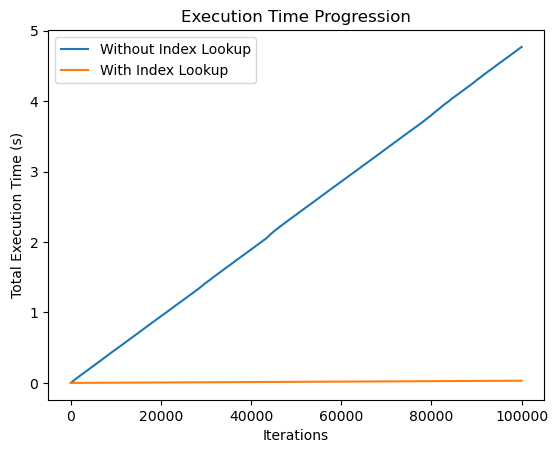

In [11]:
# Plot execution times
plt.plot(execution_times_no_dict, label="Without Index Lookup")
plt.plot(execution_times_dict, label="With Index Lookup")
plt.xlabel("Iterations")
plt.ylabel("Total Execution Time (s)")
plt.title("Execution Time Progression")
plt.legend()
plt.show()

#### Lookup by Set Unique Prices and Normal Lookup

In [12]:
# Generates 100 prices
prices = [random.randint(100, 5000) for _ in range(100)]
total_time_no_set = 0
total_time_set = 0

check_promotion_price = Inventory('laptops_dqds.csv')

# Lists to store execution times for each iteration
execution_times_no_set = []
execution_times_set = []

for price in prices:
    # For get_laptop_by_id() method
    start = time.time()
    check_promotion_price.check_promotion_dollars_using_linear_row(price)
    end = time.time()
    total_time_no_set += end - start
    execution_times_no_set.append(total_time_no_set)  # Store execution time

    # For get_laptop_by_index_id() method
    start = time.time()
    check_promotion_price.check_promotion_dollars(price)
    end = time.time()
    total_time_set += end - start
    execution_times_set.append(total_time_set)  # Store execution time

print(f"Total time without index lookup: {total_time_no_set}")
print(f"Total time with index lookup: {total_time_set}")

Total time without index lookup: 0.6262781620025635
Total time with index lookup: 0.0004296302795410156


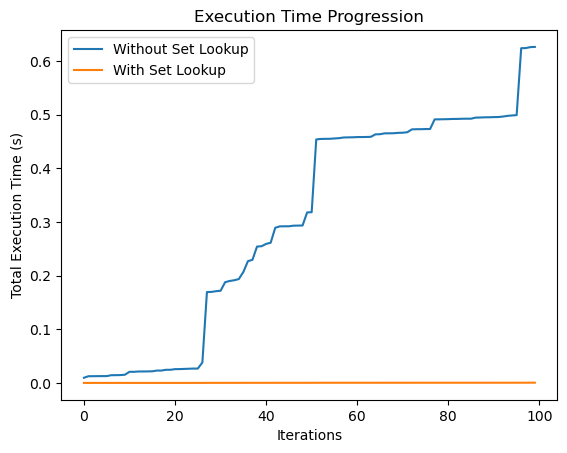

In [13]:
# Plot execution times
plt.plot(execution_times_no_set, label="Without Set Lookup")
plt.plot(execution_times_set, label="With Set Lookup")
plt.xlabel("Iterations")
plt.ylabel("Total Execution Time (s)")
plt.title("Execution Time Progression")
plt.legend()
plt.show()

### Testing out the `Inventory` class

Printing out the headers

In [14]:
inventory_test = Inventory('laptops_dqds.csv')
print("Header:", inventory_test.header)

Header: ['Id', 'Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price']


Printing out the indexed rows

In [15]:
print("First five rows:", inventory_test.indexed_row)

First five rows: {'6571244': ['6571244', 'Apple', 'MacBook Pro', 'Ultrabook', '13.3', 'IPS Panel Retina Display 2560x1600', 'Intel Core i5 2.3GHz', '8GB', '128GB SSD', 'Intel Iris Plus Graphics 640', 'macOS', '1.37kg', 1339], '7287764': ['7287764', 'Apple', 'Macbook Air', 'Ultrabook', '13.3', '1440x900', 'Intel Core i5 1.8GHz', '8GB', '128GB Flash Storage', 'Intel HD Graphics 6000', 'macOS', '1.34kg', 898], '3362737': ['3362737', 'HP', '250 G6', 'Notebook', '15.6', 'Full HD 1920x1080', 'Intel Core i5 7200U 2.5GHz', '8GB', '256GB SSD', 'Intel HD Graphics 620', 'No OS', '1.86kg', 575], '9722156': ['9722156', 'Apple', 'MacBook Pro', 'Ultrabook', '15.4', 'IPS Panel Retina Display 2880x1800', 'Intel Core i7 2.7GHz', '16GB', '512GB SSD', 'AMD Radeon Pro 455', 'macOS', '1.83kg', 2537], '8550527': ['8550527', 'Apple', 'MacBook Pro', 'Ultrabook', '13.3', 'IPS Panel Retina Display 2560x1600', 'Intel Core i5 3.1GHz', '8GB', '256GB SSD', 'Intel Iris Plus Graphics 650', 'macOS', '1.37kg', 1803], '8

Printing out the shape or the size of the dataset

In [16]:
print(len(inventory_test.linear_rows))

1303


Using `get_laptop_by_id()` method

In [17]:
print(inventory_test.get_laptop_by_id('213131'))

None


In [18]:
print(inventory_test.get_laptop_by_id('9722156'))

['9722156', 'Apple', 'MacBook Pro', 'Ultrabook', '15.4', 'IPS Panel Retina Display 2880x1800', 'Intel Core i7 2.7GHz', '16GB', '512GB SSD', 'AMD Radeon Pro 455', 'macOS', '1.83kg', 2537]


Using get_laptop_from_id_fast

In [19]:
print(inventory_test.get_laptop_by_id('7931331'))

['7931331', 'HP', '250 G6', 'Notebook', '15.6', '1366x768', 'Intel Core i5 7200U 2.5GHz', '4GB', '500GB HDD', 'Intel HD Graphics 620', 'No OS', '1.86kg', 393]


Using check_promotion_dollars() method

In [20]:
print(inventory_test.check_promotion_dollars(442))

False


In [21]:
print(inventory_test.check_promotion_dollars(1000))

True


Using find_first_laptop_more_expensive() method to find the next expensive laptop given the price

In [22]:
print(inventory_test.find_first_laptop_more_expensive(1000))  # Step 4
print(inventory_test.find_first_laptop_more_expensive(5000)) # Step 5

8747948
3319961


In [23]:
print(inventory_test.find_laptop_by_price(1000))

6676297


Using find_min_and_max_laptop_by_price() to find the range of prices given the min_price and max_price argument

In [24]:
print(inventory_test.find_min_and_max_laptop_by_price(2000,2538))
print(inventory_test.get_laptop_by_id('9722156'))

('5978354', '9722156')
['9722156', 'Apple', 'MacBook Pro', 'Ultrabook', '15.4', 'IPS Panel Retina Display 2880x1800', 'Intel Core i7 2.7GHz', '16GB', '512GB SSD', 'AMD Radeon Pro 455', 'macOS', '1.83kg', 2537]


---

# Data Cleaning and Transformation Using *PySpark*

In this section, we will clean the `laptops.csv` file using *PySpark*. The dataset, sourced from Kaggle, has been intentionally dirtied to provide challenges and allow us to demonstrate various cleaning methods. While the dataset is small and could be handled with pandas, we use *PySpark* to simulate cleaning a large dataset that might come from a data pipeline.

At the end of this section, we will save a clean and transformed version of `laptops.csv`.


## *Dirtify* the Data

You might wonder why we intentionally introduced imperfections into a perfectly fine dataset. The rationale behind this step is to simulate real-world data cleaning scenarios and to fully utilize the capabilities of *PySpark* for data transformation and cleansing. In real-world applications, datasets are often messy and require extensive cleaning. By introducing controlled "dirtiness" into our dataset, we can better prepare for these challenges.

Key Changes in the `Dirtify` Process

1. **Introducing Randomness/Null Values**: We added noise and null values to specified columns to mimic the inconsistencies often found in real-world datasets.
2. **Introducing Typos**: We randomly inserted typos to simulate human errors commonly encountered in data entry.

Protected Fields

While we introduced imperfections, we ensured to protect certain critical fields from these operations to maintain the integrity of essential data. These protected fields include `Product`, `Id`, and `Company`. Although we allowed minor modifications like misuse of capitalization, we avoided destructive changes such as setting these fields to null.

By dirtying the dataset, we can demonstrate effective data cleaning techniques and showcase the robustness of *PySpark* in handling and cleaning imperfect data.

#### Initialize Pandas dataframe

We will use pandas to *Dirtify* the dataset

In [25]:
test = pd.read_csv('laptops_clean.csv', encoding='latin1')

In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [27]:
# Read the CSV file into a DataFrame
dirtify_laptop = pd.read_csv('laptops_clean.csv', encoding='latin1')

#### Adding Typos

In this section we will introduce typos in the `Company` column. We will exclude `Product` as this is unfeasable to clean due to the names of the Product having a non dictionary word. 

In [28]:
def introduce_typos(df, columns):
    """Introduce simple character shifts or character additions at random positions in specific columns to simulate typos."""
    def introduce_typo(word):
        """Introduce a typo in a word by either shifting a character or adding a new character at a random position."""
        if len(word) > 1:
            pos = np.random.randint(0, len(word))
            if np.random.rand() < 0.5:  # 50% chance of shifting the character
                # Ensure character remains printable
                shifted_char = chr((ord(word[pos]) + np.random.choice([-1, 1])) % 128)
                return word[:pos] + shifted_char + word[pos+1:]
            else:  # 50% chance of adding a new character
                new_char = chr(np.random.randint(65, 123))  # Choose a random alphabetic ASCII character
                return word[:pos] + new_char + word[pos:]
        else:
            return word  # Return the word as is if too short to modify meaningfully

    for col in columns:
        # Ensure all data in the column are strings
        df[col] = df[col].astype(str)
        indices = df.sample(frac=0.1, random_state=42).index
        df.loc[indices, col] = df.loc[indices, col].apply(introduce_typo)
        
    return df  # Return the modified DataFrame
    
# Introduce typos in non-critical fields
dirtify_laptop = introduce_typos(dirtify_laptop, ['Company'])

### Introducing Duplicates with Error

We will make some duplicates have outlandish values. This makes it have a classification that the row generated is a duplicate to its data outliers. 

In [29]:
def create_error_duplicates(df, num_duplicates=1):
    """Create specified number of duplicates from original rows, increment IDs, and introduce random but extreme errors.
    
    Parameters:
        df (DataFrame): Original DataFrame.
        num_duplicates (int): Number of times to duplicate the original data with modifications.
        
    Returns:
        DataFrame: Original data combined with duplicates.
    """
    final_df = pd.DataFrame()  # Initialize an empty DataFrame for the final result
    max_id = df['laptop_ID'].max()  # Calculate maximum laptop_ID once

    # Define a helper function to generate random or null values
    def random_or_null(threshold_low, threshold_high, null_prob=0.03, format_str=None):
        if np.random.rand() < null_prob:
            return np.nan  # Introduce nulls with a 3% probability
        else:
            random_value = np.random.uniform(threshold_low, threshold_high)
            return format_str.format(random_value) if format_str else round(random_value, 2)

    # Duplicate and modify the data
    for n in range(num_duplicates):
        duplicates = df.copy()
        increment = (n + 1) * (max_id + 1)
        duplicates['laptop_ID'] += increment
        duplicates['Inches'] = duplicates['Inches'].apply(lambda x: random_or_null(20, 100))
        duplicates['Ram'] = duplicates['Ram'].apply(lambda x: random_or_null(120, 512, format_str="{:.0f}GB"))
        duplicates['Weight'] = duplicates['Weight'].apply(lambda x: random_or_null(30, 200, format_str="{:.2f}kg"))
        duplicates['Price_euros'] = duplicates['Price_euros'].apply(lambda x: random_or_null(150000, 999999))

        final_df = pd.concat([final_df, duplicates], ignore_index=True)

    # Combine the original DataFrame with the modified duplicates
    combined_df = pd.concat([df, final_df], ignore_index=True)

    # Verification step: Check if the original data is still present
    if not df.equals(combined_df.head(len(df))):
        raise ValueError("The original data has been altered.")

    # Return the combined DataFrame
    return combined_df

    
# Generate duplicate rows with data errors
dirtify_laptop = create_error_duplicates(dirtify_laptop, num_duplicates=100)

In [30]:
original_rows = pd.read_csv('laptops_clean.csv', encoding='latin1')
duplicated_rows = dirtify_laptop[len(pd.read_csv('laptops_clean.csv', encoding='latin1')):]

print("Original Rows:")
#print(original_rows)
print("\nDuplicated Rows with Errors:")
#print(duplicated_rows)

Original Rows:

Duplicated Rows with Errors:


Check if all ids are unique

In [31]:
# Check if all laptop_IDs are unique
are_ids_unique = not dirtify_laptop['laptop_ID'].duplicated().any()

if are_ids_unique:
    print("All laptop IDs are unique.")
else:
    print("Duplicate laptop IDs found.")

All laptop IDs are unique.


### Save to .csv named `laptops_dirty.csv`

In [32]:
dirtify_laptop.to_csv('laptops_dirty.csv', index=False)

## Start the Spark Session!

Let's first initialize our spark session

In [33]:
# Create Spark session with adjusted settings
spark = SparkSession.builder \
    .appName("Laptop ETL") \
    .config("spark.jars", config.JDBC_DRIVER_PATH) \
    .getOrCreate()


24/06/12 13:51:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [34]:
spark

Load the data on to `laptops` dataframe

In [35]:
laptops = spark.read.csv("laptops_dirty.csv", header=True, inferSchema=True)

# Intialize ETL classes
cleaner_util = DataCleanerUtil(spark) 
transform_util = DataTransformUtil(spark)
data_loader_util = DataLoadUtil()

In [36]:
laptops.count()

131603

In [37]:
laptops.printSchema()

root
 |-- laptop_ID: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- TypeName: string (nullable = true)
 |-- Inches: double (nullable = true)
 |-- ScreenResolution: string (nullable = true)
 |-- Cpu: string (nullable = true)
 |-- Ram: string (nullable = true)
 |-- Memory: string (nullable = true)
 |-- Gpu: string (nullable = true)
 |-- OpSys: string (nullable = true)
 |-- Weight: string (nullable = true)
 |-- Price_euros: double (nullable = true)



In [38]:
laptops.describe('Price_euros').show()

+-------+------------------+
|summary|       Price_euros|
+-------+------------------+
|  count|            127776|
|   mean| 569975.2854700414|
| stddev|250905.52938557783|
|    min|             174.0|
|    max|         999994.82|
+-------+------------------+



---

## What Can Be Cleaned in the Dataset?

- **Overview of the Dataset**: Use `df.printSchema` to get an overview of the dataset.
- **Null Values**: Check for any null values in the dataset.
- **Duplicates**: Check for duplicates, ensuring uniqueness in the `Product` column.

Note: We are intentionally ignoring the modifications made in the *Dirtify* step. (*Dirtify*—what kind of word is that?)


### Print Schema

In [39]:
laptops.printSchema()

root
 |-- laptop_ID: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- TypeName: string (nullable = true)
 |-- Inches: double (nullable = true)
 |-- ScreenResolution: string (nullable = true)
 |-- Cpu: string (nullable = true)
 |-- Ram: string (nullable = true)
 |-- Memory: string (nullable = true)
 |-- Gpu: string (nullable = true)
 |-- OpSys: string (nullable = true)
 |-- Weight: string (nullable = true)
 |-- Price_euros: double (nullable = true)



### Check for null-values

There are null values on:

1. Inches
2. Ram
3. Weight
4. Price_Euroes

In [40]:
cleaner_util.print_null_counts(laptops)

laptop_ID: 0 null values
Company: 0 null values
Product: 0 null values
TypeName: 0 null values
Inches: 3846 null values
ScreenResolution: 0 null values
Cpu: 0 null values
Ram: 3900 null values
Memory: 0 null values
Gpu: 0 null values
OpSys: 0 null values
Weight: 3975 null values
Price_euros: 3827 null values


### Check for duplicates

We will check the columns that are supposed to be unique. Looking at the printed results looks like laptop_id is unique which is good and

In [41]:
columns_to_check = ['Product','laptop_ID']
_ = [cleaner_util.column_has_duplicates(laptops ,column, enable_printing=True) for column in columns_to_check]


Duplicates found in column 'Product': 618
No duplicates found in column 'laptop_ID'


---
### Prototyping our Data Cleaning Methods

Before performing any cleaning operations on the dataset, it's essential to understand its current structure and content. This understanding enables us to develop more effective cleaning strategies. To achieve this, we will leverage the capabilities of *Pandas*, a powerful library known for its data analysis and manipulation functionalities.

After creating our prototype methods, we will transfer them to our `DataCleanerUtil`.

In [42]:
laptops_pd = laptops.toPandas()

---
#### Sampling the laptops_pd

Looking at the sample, columns `Weight`, `Price_euros` ,`Inches` , and `RAM` has some unrealistic values. These rows might be bad data.

In [43]:
laptops_pd.sample(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
34532,35008,HP,250 G6,Notebook,97.29,1366x768,Intel Core i3 6006U 2GHz,371GB,500GB HDD,Intel HD Graphics 520,No OS,188.77kg,605077.96
78596,79683,Dell,Latitude 3380,Notebook,51.45,1366x768,Intel Core i3 6006U 2GHz,467GB,128GB SSD,Intel HD Graphics 520,Windows 10,146.81kg,348603.66
113857,115430,Lenovo,Ideapad 520-15IKBR,Notebook,99.07,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,382GB,256GB SSD,Intel UHD Graphics 620,Windows 10,100.77kg,185762.22
24281,24614,Dell,Latitude 3480,Notebook,82.38,1366x768,Intel Core i3 6006U 2GHz,229GB,500GB HDD,Intel HD Graphics 520,Windows 10,117.82kg,NaN
386,392,Lenovo,Ideapad 510S-13IKB,Notebook,13.30,IPS Panel Full HD 1920x1080,Intel Core i3 7100U 2.4GHz,4GB,128GB SSD,Intel HD Graphics 620,Windows 10,1.5kg,549.00


---
#### Checking the Duplicate Product

As I mentioned earlier, `Product` column must be unique. Based on the output of the code below, looks like there are cases that the duplicate `Product` contains the unrealistic or bad data values. 

In [44]:
laptops_pd.query('Product == "ThinkPad X270"').sample(n=1, random_state=42) 

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
62202,63062,Lenovo,ThinkPad X270,Ultrabook,82.49,IPS Panel Full HD 1920x1080,Intel Core i5 7300U 2.6GHz,222GB,256GB SSD,Intel HD Graphics 620,Windows 10,109.26kg,795912.06


---
#### Value Counts for Category Columns

Now we will look on to some category columns, `Company` and `Opsys` are category columns. Let's do an aggregation by value counts to see what are the data.

Based on the output we can come with this conclusion:

1. `Company` column values has typos, we should Normilize this based on existing Company Brands. 
2. `OpSys` column values looks normal as there are no Typos.

In [45]:
laptops_pd['Company'].value_counts().head(30)

Company
Lenovo       27573
Dell         26664
HP           24745
Asus         14241
Acer          9595
MSI           4949
Toshiba       4343
Apple         2020
Samsung        707
Razer          606
HO             606
Dfll           606
Mediacom       505
Microsoft      505
IP             404
Delm           404
Vero           404
Google         303
Lenowo         303
GP             303
Lenovn         303
Asur           303
Fujitsu        303
LG             303
Chuwi          303
Dekl           303
Asut           202
@sus           202
Asts           202
PHP            202
Name: count, dtype: int64

In [46]:
laptops_pd['OpSys'].value_counts()

OpSys
Windows 10      108272
No OS             6666
Linux             6262
Windows 7         4545
Chrome OS         2727
macOS             1313
Mac OS X           808
Windows 10 S       808
Android            202
Name: count, dtype: int64

---
#### Replacing Typos in the `Company` column

We'll rectify typos in the text by comparing them with the correct `Company` name. But how can we identify a typo and substitute it with the accurate string? Here's the logic we'll employ:

We'll calculate the difference between the strings. Consider these examples:
- Lenovp -> Lenovo
- Lenovp -> Apple

At first glance, it's evident that the first one matches the word "Lenovo" better than the second. But how do we compute this? We can attempt to *replace*, *insert*, or *delete* characters from the strings until they match. Then, we'll tally the number of operations performed, which will serve as our difference factor.

This approach is known as the **Levenshtein Distance Algorithm** or Minimum Edit Distance. It determines the minimum operations required to make two strings identical. Widely used in search engines and typo correction, this algorithm is ideal for our task. For more information, you can access  [video]('https://www.youtube.com/watch?v=Dd_NgYVOdLk&t=272s') and also [this]('https://medium.com/@ethannam/understanding-the-levenshtein-distance-equation-for-beginners-c4285a5604f0') which are great resources in learning this Algorithm.

Furthermore, we will use [fuzzywuzzy]('https://pypi.org/project/fuzzywuzzy/'), a great library that implements this algorithm. We will set the threshold to *50%* as there are many typos in the dataset. 

Let's test our method first to a copy of `laptops_pd`

In [47]:
laptops.printSchema()

root
 |-- laptop_ID: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- TypeName: string (nullable = true)
 |-- Inches: double (nullable = true)
 |-- ScreenResolution: string (nullable = true)
 |-- Cpu: string (nullable = true)
 |-- Ram: string (nullable = true)
 |-- Memory: string (nullable = true)
 |-- Gpu: string (nullable = true)
 |-- OpSys: string (nullable = true)
 |-- Weight: string (nullable = true)
 |-- Price_euros: double (nullable = true)



In [48]:
companies = [
    'Lenovo', 'Dell', 'HP', 'Asus', 'Acer', 'MSI', 'Toshiba', 'Apple', 'Samsung', 
    'Razer', 'Microsoft', 'Mediacom', 'Vero', 'Google', 'Chuwi', 'Fujitsu', 'LG', 
    'Xiaomi', 'Huawei'
]

def correct_company_names(row, threshold, valid_companies):
    # Use fuzzy matching to find the closest valid company name
    highest_match = process.extractOne(row['Company'], valid_companies)
    if highest_match[1] >= threshold: 
        return highest_match[0]
    return row['Company']


# Sample 5000 rows from the DataFrame
df_sampled = laptops_pd.sample(n=100, random_state=42).copy()

threshold = 50

# Apply the correction function to the DataFrame
df_sampled['Company'] = df_sampled.apply(
    correct_company_names,
    threshold=threshold,
    valid_companies=companies,
    axis=1
)


In [49]:
df_sampled.value_counts('Company').head(19)

Company
Lenovo       26
Dell         22
HP           18
Asus         14
Acer          9
MSI           6
Toshiba       3
Apple         1
Microsoft     1
Name: count, dtype: int64

Its a match! Looks like the best threshold is `50%`. The probable reason behind this is that the typos on the `Company` column are minor, *Dekl* is almost similar to *Dell* but with a few slight alterations. Another reason is that the typos and the original texts are almost equal in lenght. So a `50%` similarity threshold effectively means that the distance between the actual company name and the typo is not more than half the length of the string. 

##### Efficient and maximising the levenstein function
Now let's move on to another scenario, supposedly we have `100,000` invalid typos and the number of valid companies is `26`. If we do the *levenstein* algorithm, we need to check every rows to each valid companies so the total computations will be `2,600,000` million rows! 

Obviously the request will take time but as Data Engineers we need to consider the resource and time constraint. Supposedly we have 4 CPU Cores and 2 worker. We can do this to utilise the full CPU cores by parallelize the operations. This will increase throughput and maximize our usage of our cores. 

Furthermore, we can also utilize Pre-Process Data techniques such as only selecting the columns to be processed before feeding it to the levenstein method.

We will do two types of fuzzy data-cleaning, one is we use the parrelization and the other is we do not. During execution of the two methods, we will take note of the execution time. We will minimise the size to `10,000`. 

###### Single Process

This data cleaning method does not use parallelization, pre-process, and splitting the work-load into chunks. 

In [50]:
companies = [
    'Lenovo', 'Dell', 'HP', 'Asus', 'Acer', 'MSI', 'Toshiba', 'Apple', 'Samsung', 
    'Razer', 'Microsoft', 'Mediacom', 'Vero', 'Google', 'Chuwi', 'Fujitsu', 'LG', 
    'Xiaomi', 'Huawei'
]

def correct_company_names(row, threshold, valid_companies):
    # Use fuzzy matching to find the closest valid company name
    highest_match = process.extractOne(row['Company'], valid_companies)
    if highest_match[1] >= threshold: 
        return highest_match[0]
    return row['Company']

# Function to get the current memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Convert bytes to MB


# Measure the start time
start_time = time.time()
start_memory = get_memory_usage()

#=============================================================================================================
df_sampled = laptops_pd.sample(n=10000, random_state=42).copy()

threshold = 50

# Apply the correction function to the DataFrame
df_sampled['Company'] = df_sampled.apply(
    correct_company_names,
    threshold=threshold,
    valid_companies=companies,
    axis=1
)
#=============================================================================================================
end_time = time.time()
end_memory = get_memory_usage()

memory_usage = end_memory - start_memory
execution_time = end_time - start_time

# Print execution time and memory usage
print(f"Execution time: {execution_time} seconds")
print(f"Memory usage: {memory_usage} MB")

Execution time: 4.7330827713012695 seconds
Memory usage: 0.0 MB


###### Parallelization Proccessing

This method uses paralleization, chunk-loading and delayed loading (We can't just push it all the CPU, we must procedurally place them or else the CPU might become overloaded), and pre-processing (Select only the columns that will be processed). For our parralleization library we have used [JobLib]('https://joblib.readthedocs.io/en/stable/') as when I created this code with only the multiprocessing lib of Python. The process does not end, so I opted to use this library instead. Also I have used [psutil]('https://pypi.org/project/psutil/') to keep track of the memory

In [51]:
valid_companies = [
    'Lenovo', 'Dell', 'HP', 'Asus', 'Acer', 'MSI', 'Toshiba', 'Apple', 'Samsung', 
    'Razer', 'Microsoft', 'Mediacom', 'Vero', 'Google', 'Chuwi', 'Fujitsu', 'LG', 
    'Xiaomi', 'Huawei'
]

def correct_company_names(company, valid_companies, threshold=50):
    highest_match = process.extractOne(company, valid_companies)
    if highest_match and highest_match[1] >= threshold:
        return highest_match[0]
    return company

def process_chunk(chunk, valid_companies, threshold=50):
    chunk['Corrected_Company'] = chunk['Company'].apply(correct_company_names, valid_companies=valid_companies, threshold=threshold)
    return chunk

# Function to get the current memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Convert bytes to MB


start_time = time.time()
start_memory = get_memory_usage()
#=======================================================================
df_sampled = laptops_pd.sample(n=10000, random_state=42).copy()

# Select only the 'columnID' and 'Company' columns
df_selected = df_sampled[['laptop_ID', 'Company']]

# Calculate the number of chunks.
# 4 cores * 2 workers = 8, but not more than the number of rows.
# This limits the number of chunks based on the number of rows,
# ensuring that the number of chunks does not exceed the number of rows.
num_chunks = min(cpu_count() * 2, len(df_selected))

# Calculate the chunk size.
# len(df_selected) // num_chunks calculates the base chunk size.
# (len(df_selected) % num_chunks > 0) ensures that any remainder rows are included,
# making sure chunk_size is an integer and all rows are covered.
chunk_size = len(df_selected) // num_chunks + (len(df_selected) % num_chunks > 0)

# Create the chunks based on the calculated num_chunks and chunk_size.
chunks = [df_selected.iloc[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]

print(f"Number of chunks: {num_chunks}")
print(f"Chunk size: {chunk_size}")
print("Chunks prepared for multiprocessing")

# Use joblib's Parallel and delayed to parallelize processing
# `delayed` is used to create a lazy representation of the function call that can be evaluated in parallel.
result_chunks = Parallel(n_jobs=num_chunks)(delayed(process_chunk)(chunk, companies) for chunk in chunks)

# Combine the results back into a single dataframe
df_corrected = pd.concat(result_chunks)

# Merge the corrected company names back into the original DataFrame
df_merged = df_sampled.merge(df_corrected[['laptop_ID', 'Corrected_Company']], on='laptop_ID', how='left')

# Drop the old 'Company' column and rename 'Corrected_Company' to 'Company'
df_merged.drop('Company', axis=1, inplace=True)
df_merged.rename(columns={'Corrected_Company': 'Company'}, inplace=True)

#=======================================================================
end_time = time.time()
end_memory = get_memory_usage()

memory_usage = end_memory - start_memory
execution_time = end_time - start_time

# Print execution time and memory usage
print(f"Execution time: {execution_time} seconds")
print(f"Memory usage: {memory_usage} MB")

Number of chunks: 24
Chunk size: 417
Chunks prepared for multiprocessing
Execution time: 2.2344465255737305 seconds
Memory usage: 1.125 MB


Using parallel processing, we achieved a significantly lower execution time compared to the single-process approach. This demonstrates the efficiency gained by distributing the workload across multiple processors. However, this performance boost comes at the cost of increased memory usage.

**Reason for Increased Memory Usage:**
- The data frame is split into multiple chunks, each of which resides in memory simultaneously before being processed by the CPU.
- With a chunk size of 417, these chunks collectively occupy more memory, contributing to the overall higher memory consumption.

**Trade-Off Consideration:**
When deciding to use parallel processing, it’s essential to balance the need for faster execution times with the available memory resources. While parallel processing can greatly reduce execution time, it requires more memory to manage the multiple chunks of data. This trade-off must be carefully considered, especially in environments with limited memory resources.


---
#### Eliminating the unrealistic Data points

During earlier analysis, we identified duplicate entries in the `Product` column with unrealistic values across certain columns. Eliminating these duplicates is crucial for ensuring the integrity of our analysis. However, it's essential to establish criteria for identifying unrealistic values within duplicate rows. To achieve this, we'll rely on empirical data.

Currently, the following columns exhibit potential discrepancies in data integrity: `Weight`, `Price_euros`, `Ram`, and `Inches`.

To set a threshold for identifying unrealistic values, we'll establish ceiling values for each of these columns:

1. **Inches**: We'll set a ceiling value of **20** inches, as this represents the maximum size for laptops.

2. **RAM**: Based on research, the maximum RAM capacity for laptops typically ranges from 64GB to 128GB, achievable through two RAM sticks (e.g., 32GB + 32GB or 64GB + 64GB). Any values exceeding this range are considered outliers. Additionally, we can apply the "4, 8, 16 rule" to validate RAM values. For example, a RAM capacity of 50GB would be deemed invalid. The condition for this is that the RAM must be a multiple of 4.

3. **Price_euros**: High-end laptops can reach prices around **€100**. We'll extend this threshold to **€10,000**. Any values exceeding this range are considered outliers or unrealistic prices.

4. **Weight**: Larger laptop models typically weigh around 4.5kg or more. Therefore, we'll set a ceiling value of **8kg**. Any weights exceeding this threshold may be physically implausible for a laptop.

By establishing these ceiling values, we can effectively identify and remove duplicate rows with unrealistic data, ensuring the quality and accuracy of our analysis.

In [52]:
# Prototype Method for removing outliers
def remove_outliers(df):
    # Define your thresholds
    max_inches = 17
    max_weight = 8  # in kg
    max_ram = 128  # assuming the unit in the dataset is GB
    reasonable_price_range = (50, 5000)  # typical price range in euros

    # Fill NaN values in 'Ram' column with 0 to avoid errors
    df['Ram'].fillna(0, inplace=True)
    
    # Convert 'Ram' from string with GB to integer for filtering
    df.loc[:, 'Ram'] = df['Ram'].replace('GB', '', regex=True).astype(int)

    # Convert 'Weight' column to numeric values and fill NaN values with 0
    df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)
    df['Weight'].fillna(0, inplace=True)
    
    # Filter based on defined thresholds
    df = df[(df['Inches'] <= max_inches) & 
            (df['Weight'] <= max_weight) & 
            (df['Ram'] <= max_ram) & 
            (df['Ram'] % 4 == 0) &  # Ensuring RAM is a multiple of 4 GB
            (df['Price_euros'] >= reasonable_price_range[0]) & 
            (df['Price_euros'] <= reasonable_price_range[1])]
    
    # Revert back the 'Weight' column to its original format
    df.loc[:, 'Weight'] = df['Weight'].astype(str) + 'kg'
    df.loc[:, 'Ram'] = df['Ram'].astype(str) + 'GB'

    return df

df_sampled = laptops_pd.sample(n=100, random_state=42).copy()

df_sampled = remove_outliers(df_sampled)

In [53]:
df_sampled.sample(2)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
1043,1057,Lenovo,Thinkpad L560,Notebook,15.6,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,2.3kg,1049.60
876,887,Asus,X541NA-GO121 (N4200/4GB/1TB/Linux),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,1TB HDD,Intel HD Graphics 505,Linux,2.0kg,398.99


Looks like our data cleaning method prototype works! Based on the sample output, there are no longer duplicate outliers in the sample dataframe. We will now use this as our basis when we do the data cleaning. 

---
### Defining Data Cleaning goals

Having assessed the dataset's structure and identified erroneous entries, we can now outline our cleaning objectives:

1. Rectify typos within the `Company` column by referencing legitimate companies present in the dataset.
2. Eliminate unrealistic data points.
3. Identify and remove duplicates, defined as entries with implausible values.
4. Address missing values by replacing them with descriptors such as 'Unknown' or 'Not Applicable' for enhanced data completeness.

#### Cleaning the Typos

We can use the `fuzzywuzzy` library that we used on our Prototype Data Cleaning section for our data-cleaning in PySpark, but there's an issue if we directly call the method in PySpark. As PySpark is a distributed computing library, we do not fully leverage the worker-node distribution if we call it directly, and it might also cause some errors. So we might use [UDF](https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/).

However, it is worth to note that **UDF** has its own consequences when using. Searching throughout the web, we can find many articles discussing this, but to have a brief overview, you can refer to this [answer](https://stackoverflow.com/questions/38296609/spark-functions-vs-udf-performance). Basically, **UDFs** in PySpark are not optimized by the Spark's Catalyst. They are expensive as unlike the default PySpark code which is under-the-hood are code in JVM (Java Code), **UDFs** are code in python that are to be transported in the JVM (Which is resource-intensive).

So it is a rule that if you want something done in PySpark, check first if you can do it using PySpark native tools. Luckily for us, PySpark has its own ['Levenshetein/Fuzzyword'](https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.functions.levenshtein.html) implementation, so we will use this instead of creating a **UDF**. 

In [54]:

threshold = 50
valid_companies = [
    'Lenovo', 'Dell', 'HP', 'Asus', 'Acer', 'MSI', 'Toshiba', 'Apple', 'Samsung', 
    'Razer', 'Microsoft', 'Mediacom', 'Vero', 'Google', 'Chuwi', 'Fujitsu', 'LG', 
    'Xiaomi', 'Huawei'
]

laptops = cleaner_util.clean_company_names(laptops,valid_companies, threshold=50)

In [55]:
test = laptops.toPandas()
test['Company'].value_counts()

Company
Dell         29997
Lenovo       29997
HP           27674
Asus         15958
Acer         10403
MSI           5454
Toshiba       4848
Apple         2121
Samsung        909
Mediacom       707
Razer          707
Microsoft      606
Vero           404
Xiaomi         404
Chuwi          303
Google         303
Fujitsu        303
LG             303
Huawei         202
Name: count, dtype: int64



The process is explained in the `clean_company_names()` method. Notice that we do not add any explicit parallelization or divide the DataFrame into chunks in the code. This is because **PySpark** already handles chunking and parallelization by default. In *PySpark*, this concept is known as [Partitioning](https://www.geeksforgeeks.org/data-partitioning-in-pyspark/), where the data is divided into partitions and distributed across the worker nodes in the cluster. Each partition is processed independently and in parallel by the workers, ensuring efficient data processernally.

#### Eliminating the outliers and Filling up Nan values
The **PySpark** method will be almost identical to our Data Prototype Method. We will use that method to drop all outliers and select only valid data.

In [56]:
laptops = cleaner_util.remove_outliers(laptops)

In [57]:
laptops.count()

1240

#### Verify the data

We will now verify the data after the data-cleaning. We will use again the `pandas` API for this task.

In [58]:
test = laptops.toPandas()

In [59]:
cleaner_util.print_null_counts(laptops)

laptop_ID: 0 null values
Company: 0 null values
Product: 0 null values
TypeName: 0 null values
Inches: 0 null values
ScreenResolution: 0 null values
Cpu: 0 null values
Ram: 0 null values
Memory: 0 null values
Gpu: 0 null values
OpSys: 0 null values
Weight: 0 null values
Price_euros: 0 null values


In [60]:
columns_to_check = ['Product','laptop_ID']
_ = [cleaner_util.column_has_duplicates(laptops,column, enable_printing=True) for column in columns_to_check]


Duplicates found in column 'Product': 175
No duplicates found in column 'laptop_ID'


Looks like there are still Duplicate `Products`, let's take a closer look with it.

##### Verifying Duplicate Columns

In [61]:
test['Product'].value_counts()

Product
XPS 13                                         30
Inspiron 3567                                  25
250 G6                                         21
Vostro 3568                                    19
Legion Y520-15IKBN                             19
                                               ..
V330-15IKB (i3-7130U/4GB/128GB/FHD/W10)         1
SmartBook 130                                   1
A541NA-GO342 (N3350/4GB/500GB/Linux)            1
17-X047na (i3-6006U/8GB/1TB/W10)                1
UX410UA-GV350T (i5-8250U/8GB/256GB/FHD/W10)     1
Name: count, Length: 587, dtype: int64

In [62]:
test[test['Product'] == 'XPS 13'].head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
19,20,Dell,XPS 13,Ultrabook,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,128GB SSD,Intel UHD Graphics 620,Windows 10,1.22kg,979.0
29,34,Dell,XPS 13,Ultrabook,13.3,Touchscreen / Quad HD+ 3200x1800,Intel Core i7 8550U 1.8GHz,16GB,512GB SSD,Intel UHD Graphics 620,Windows 10,1.2kg,1869.0
74,91,Dell,XPS 13,Ultrabook,13.3,IPS Panel Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows 10,1.21kg,1649.0
93,114,Dell,XPS 13,Ultrabook,13.3,Quad HD+ / Touchscreen 3200x1800,Intel Core i7 7560U 2.4GHz,8GB,256GB SSD,Intel Iris Plus Graphics 640,Windows 10,1.23kg,1379.0
96,117,Dell,XPS 13,Ultrabook,13.3,IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows 10,1.21kg,1629.0


In [63]:
test[test['Product'] == 'Inspiron 3567'].head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
13,14,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,256GB SSD,AMD Radeon R5 M430,Windows 10,2.2kg,498.90
16,17,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,AMD Radeon R5 M430,Windows 10,2.2kg,745.00
23,26,Dell,Inspiron 3567,Notebook,15.6,1366x768,Intel Core i3 6006U 2GHz,4GB,1TB HDD,Intel HD Graphics 520,Windows 10,2.3kg,418.64
42,49,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,AMD Radeon R5 M430,Windows 10,2.3kg,639.00
81,98,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R5 M430,Linux,2.2kg,599.90


In [64]:
test[test['Product'] == '250 G6'].head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
10,11,HP,250 G6,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,393.90
11,12,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,500GB HDD,Intel HD Graphics 520,No OS,1.86kg,344.99
34,39,HP,250 G6,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,1TB HDD,Intel HD Graphics 620,Windows 10,1.86kg,488.69
54,66,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.86kg,690.00


In [65]:
test[test['Product'] == 'Vostro 3568'].head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
230,268,Dell,Vostro 3568,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,1TB HDD,Intel HD Graphics 620,Windows 10,2.18kg,657.0
415,488,Dell,Vostro 3568,Notebook,15.6,1366x768,Intel Core i3 7100U 2.4GHz,4GB,1TB HDD,Intel HD Graphics 620,Windows 10,2.18kg,586.6
484,566,Dell,Vostro 3568,Notebook,15.6,1366x768,Intel Core i3 6006U 2GHz,4GB,1TB HDD,AMD Radeon R5 M420,Windows 10,2.18kg,617.9
520,611,Dell,Vostro 3568,Notebook,15.6,1366x768,Intel Core i3 6006U 2GHz,4GB,1TB HDD,AMD Radeon R5 M420,Linux,2.18kg,465.0
527,619,Dell,Vostro 3568,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,Linux,2.18kg,443.9


Looking at the these values, it seems that the `Product` is the same but its component are entirely different. So we will be rest-assured that these data are not bad data. 


## Data Transformation

In this step, we will transform the dataset to facilitate easier analysis using *pandas*. Our strategy is to *atomize* or split the columns to increase flexibility during the data analysis phase. However, we will balance this approach to avoid excessive atomization, which can lead to data redundancy and sparsity.

One significant advantage of atomization is that it saves space in the database. Distinct CPUs, GPUs, and ScreenTypes will be stored in separate tables, while the main `laptops` table will reference these entries via foreign keys. This approach not only reduces redundancy but also enhances data integrity and consistency.

### Transforming Screen-Resolution 

ScreenResolution can be splitted into two columns; `ScreenSize` and `DisplayType`.

In [66]:
laptops = transform_util.split_screen_resolution(laptops)

In [67]:
sample = laptops.filter(col("DisplayType").contains("Full HD"))

sample_pandas = sample.toPandas()  
sample_pandas.sample(10)

,laptop_ID,Company,Product,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenSize,DisplayType
345,580,Lenovo,Thinkpad E570,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.3kg,830.00,1920x1080,Full HD
228,390,Asus,Zenbook Flip,Ultrabook,13.3,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.1kg,1748.90,1920x1080,Full HD / Touchscreen
331,552,HP,ProBook 450,Notebook,15.6,Intel Core i3 7100U 2.4GHz,4GB,128GB SSD,Intel HD Graphics 620,Windows 10,2.1kg,705.50,1920x1080,Full HD
295,501,Asus,Rog G752VL-UH71T,Gaming,17.3,Intel Core i7 6700HQ 2.6GHz,24GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 965M,Windows 10,4.33kg,1269.00,1920x1080,IPS Panel Full HD / Touchscreen
794,1232,Asus,ROG Strix,Gaming,17.3,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows 10,2.9kg,1949.00,1920x1080,Full HD
55,106,HP,Envy 13-ad009n,Ultrabook,13.3,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,Nvidia GeForce MX150,Windows 10,1.38kg,1119.00,1920x1080,IPS Panel Full HD
369,624,HP,EliteBook 850,Ultrabook,15.6,Intel Core i7 7500U 2.7GHz,8GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.84kg,1389.00,1920x1080,Full HD
124,220,Dell,Inspiron 5370,Ultrabook,13.3,Intel Core i7 8550U 1.8GHz,8GB,256GB SSD,AMD Radeon 530,Windows 10,1.4kg,931.88,1920x1080,IPS Panel Full HD
454,780,Samsung,Notebook 9,2 in 1 Convertible,15.0,Intel Core i7 7500U 2.7GHz,16GB,256GB SSD,AMD Radeon 540,Windows 10,1.71kg,1799.00,1920x1080,Full HD / Touchscreen
572,986,Dell,Alienware 17,Gaming,17.3,Intel Core i7 6700HQ 2.6GHz,32GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42kg,2800.00,1920x1080,Full HD


### Transforming Cpu 

Cpu column has three part: {Brand} {Model} {Speed}. Splitting these parts will make analysis such as brand analysis or CPU speead analysis much easier. 
We will split these column into three columns; `CpuBrand`, `CpuModel`, `CpuSpeed`

In [68]:
laptops = transform_util.split_cpu(laptops)

#### Verifying the Data Transformation

In [69]:
amd_cpus = laptops.filter(col("Cpu").contains("AMD"))

amd_cpu_pandas = amd_cpus.toPandas()  
amd_cpu_pandas.sample(10)

,laptop_ID,Company,Product,TypeName,Inches,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenSize,DisplayType,CpuBrand,CpuModel,CpuSpeed
30,725,Lenovo,110-15ACL (A6-7310/4GB/500GB/W10),Notebook,15.6,4GB,500GB HDD,AMD Radeon R4,Windows 10,2.19kg,298.00,1366x768,Unknown,AMD,A6-Series 7310,2GHz
42,104,HP,15-bw000nv (E2-9000e/4GB/500GB/Radeon,Notebook,15.6,4GB,500GB HDD,AMD Radeon R2,Windows 10,2.1kg,349.00,1920x1080,Full HD,AMD,E-Series E2-9000e,1.5GHz
3,53,HP,255 G6,Notebook,15.6,4GB,256GB SSD,AMD Radeon R4 Graphics,Windows 10,1.86kg,398.49,1920x1080,Full HD,AMD,A6-Series 9220,2.5GHz
35,1104,Acer,Aspire ES1-523,Notebook,15.6,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.4kg,387.00,1366x768,Unknown,AMD,A8-Series 7410,2.2GHz
25,500,Acer,Aspire 5,Notebook,15.6,8GB,1TB HDD,AMD Radeon RX 540,Windows 10,2.2kg,579.00,1366x768,Unknown,AMD,A10-Series 9620P,2.5GHz
16,318,Acer,ES1-523-84K7 (A8-7410/8GB/256GB/FHD/W10),Notebook,15.6,8GB,256GB SSD,AMD Radeon R5,Windows 10,2.23kg,469.00,1920x1080,Full HD,AMD,A8-Series 7410,2.2GHz
43,236,HP,15-rb013nv (E2-9000e/4GB/500GB/W10),Notebook,15.6,4GB,500GB HDD,AMD Radeon R2,Windows 10,2.1kg,330.00,1366x768,Unknown,AMD,E-Series 9000e,1.5GHz
13,257,Asus,X505BP-BR019T (A9-9420/4GB/1TB/Radeon,Notebook,15.6,4GB,1TB HDD,AMD Radeon R5 M420,Windows 10,1.68kg,469.00,1366x768,Unknown,AMD,A9-Series 9420,3GHz
31,737,HP,15-BW037na (A9-9420/4GB/1TB/Radeon,Notebook,15.6,4GB,1TB HDD,AMD Radeon 520,Windows 10,2.1kg,489.00,1920x1080,Full HD,AMD,A9-Series 9420,3GHz
5,86,Acer,Aspire 3,Notebook,15.6,4GB,1TB HDD,AMD Radeon R5,Windows 10,2.1kg,395.00,1366x768,Unknown,AMD,A9-Series 9420,3GHz


In [70]:
intel_cpus = laptops.filter(col("Cpu").contains("Intel"))

intel_cpus = intel_cpus.toPandas() 
intel_cpus.sample()

,laptop_ID,Company,Product,TypeName,Inches,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenSize,DisplayType,CpuBrand,CpuModel,CpuSpeed
667,820,MSI,GE72MVR 7RG,Gaming,17.3,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg,2415.0,1920x1080,Full HD,Intel,Core i7 7700HQ,2.8GHz


### Transforming Gpu

We will create a new column called `GpuBrand` and rename the `Gpu` column to `GpuModel`

In [71]:
laptops = transform_util.split_gpu(laptops)

#### Verifying Gpu transformation

In [72]:
gpu_brand_counts = laptops.groupBy("GpuBrand").count()
gpu_brand_counts_pandas = gpu_brand_counts.toPandas()  
print(gpu_brand_counts_pandas)

  GpuBrand  count
0      ARM      1
1      AMD    160
2    Intel    690
3   Nvidia    389


In [73]:
test = laptops.toPandas()  

In [74]:
test.head()

,laptop_ID,Company,Product,TypeName,Inches,Ram,Memory,GpuModel,OpSys,Weight,Price_euros,ScreenSize,DisplayType,CpuBrand,CpuModel,CpuSpeed,GpuBrand
0,1,Apple,MacBook Pro,Ultrabook,13.3,8GB,128GB SSD,Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPS Panel Retina Display,Intel,Core i5,2.3GHz,Intel
1,2,Apple,Macbook Air,Ultrabook,13.3,8GB,128GB Flash Storage,HD Graphics 6000,macOS,1.34kg,898.94,1440x900,Unknown,Intel,Core i5,1.8GHz,Intel
2,3,HP,250 G6,Notebook,15.6,8GB,256GB SSD,HD Graphics 620,No OS,1.86kg,575.00,1920x1080,Full HD,Intel,Core i5 7200U,2.5GHz,Intel
3,4,Apple,MacBook Pro,Ultrabook,15.4,16GB,512GB SSD,Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPS Panel Retina Display,Intel,Core i7,2.7GHz,AMD
4,5,Apple,MacBook Pro,Ultrabook,13.3,8GB,256GB SSD,Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPS Panel Retina Display,Intel,Core i5,3.1GHz,Intel


### Weight to Weight KG

In this section, we will convert `Weight` to a numeric value called `WeightKG`. 

In [75]:
laptops = transform_util.weight_to_weight_kg(laptops)

In [76]:
laptops.show(1)

+---------+-------+-----------+---------+------+---+---------+--------------------+-----+-----------+----------+--------------------+--------+--------+--------+--------+--------+
|laptop_ID|Company|    Product| TypeName|Inches|Ram|   Memory|            GpuModel|OpSys|Price_euros|ScreenSize|         DisplayType|CpuBrand|CpuModel|CpuSpeed|GpuBrand|WeightKG|
+---------+-------+-----------+---------+------+---+---------+--------------------+-----+-----------+----------+--------------------+--------+--------+--------+--------+--------+
|        1|  Apple|MacBook Pro|Ultrabook|  13.3|8GB|128GB SSD|Iris Plus Graphic...|macOS|    1339.69| 2560x1600|IPS Panel Retina ...|   Intel| Core i5|  2.3GHz|   Intel|    1.37|
+---------+-------+-----------+---------+------+---+---------+--------------------+-----+-----------+----------+--------------------+--------+--------+--------+--------+--------+
only showing top 1 row



In [77]:
test_pandas = laptops.toPandas() 

In [78]:
test_pandas.sample(1)

,laptop_ID,Company,Product,TypeName,Inches,Ram,Memory,GpuModel,OpSys,Price_euros,ScreenSize,DisplayType,CpuBrand,CpuModel,CpuSpeed,GpuBrand,WeightKG
195,229,Dell,Alienware 17,Gaming,17.3,16GB,256GB SSD + 1TB HDD,GeForce GTX 1060,Windows 10,2456.34,1920x1080,IPS Panel Full HD,Intel,Core i7 7700HQ,2.8GHz,Nvidia,4.42


### Change types to float

In [79]:
# Cast columns to float without renaming
laptops = laptops.withColumn("Inches", col("Inches").cast("float")) \
       .withColumn("WeightKG", col("WeightKG").cast("float")) \
       .withColumn("Price_euros", col("Price_euros").cast("float"))

---
## Final Schema

In [80]:
laptops.count()

1240

In [81]:
laptops.printSchema()

root
 |-- laptop_ID: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- TypeName: string (nullable = true)
 |-- Inches: float (nullable = true)
 |-- Ram: string (nullable = true)
 |-- Memory: string (nullable = true)
 |-- GpuModel: string (nullable = true)
 |-- OpSys: string (nullable = true)
 |-- Price_euros: float (nullable = true)
 |-- ScreenSize: string (nullable = true)
 |-- DisplayType: string (nullable = true)
 |-- CpuBrand: string (nullable = true)
 |-- CpuModel: string (nullable = true)
 |-- CpuSpeed: string (nullable = true)
 |-- GpuBrand: string (nullable = true)
 |-- WeightKG: float (nullable = true)



Saving the laptops to a .csv

In [82]:
save_directory = "out\laptops"

data_loader_util.save_with_timestamp(laptops, save_directory)

File saved as out\laptops/laptops_20240612135153.csv


## Load to DB

This section presents the final schema for the `laptops` DataFrame. In the next section, we will focus on exporting, or in other words, *serving* the data to ensure it is ready for analysis or can be fed into a Machine Learning algorithm. Specifically, we will load the DataFrame into our PostgreSQL database.

One significant advantage of normalizing the data is that we can reduce the row count in the `laptops`, `GPU`, and `CPU` tables by using foreign keys. This approach not only decreases redundancy but also enhances data integrity and consistency. Each laptop entry in the `laptops` table will reference the corresponding entries in the `GPU` and `CPU` tables via foreign keys.



As mentioned earlier, we will create four tables:

1. `laptops`
2. `GPU`
3. `screen_resolution`
4. `CPU`

Our strategy for inserting data is called `Upsert`. Upsert is a combination of "update" and "insert." This method allows us to insert new records into the database if they do not exist. If a record with the same primary key already exists, the existing record will be updated with the new data instead of inserting a duplicate. This approach helps avoid conflicts with duplicate primary keys and ensures data integrity.

The Entity-Relationship Diagram (ERD) is as follows:

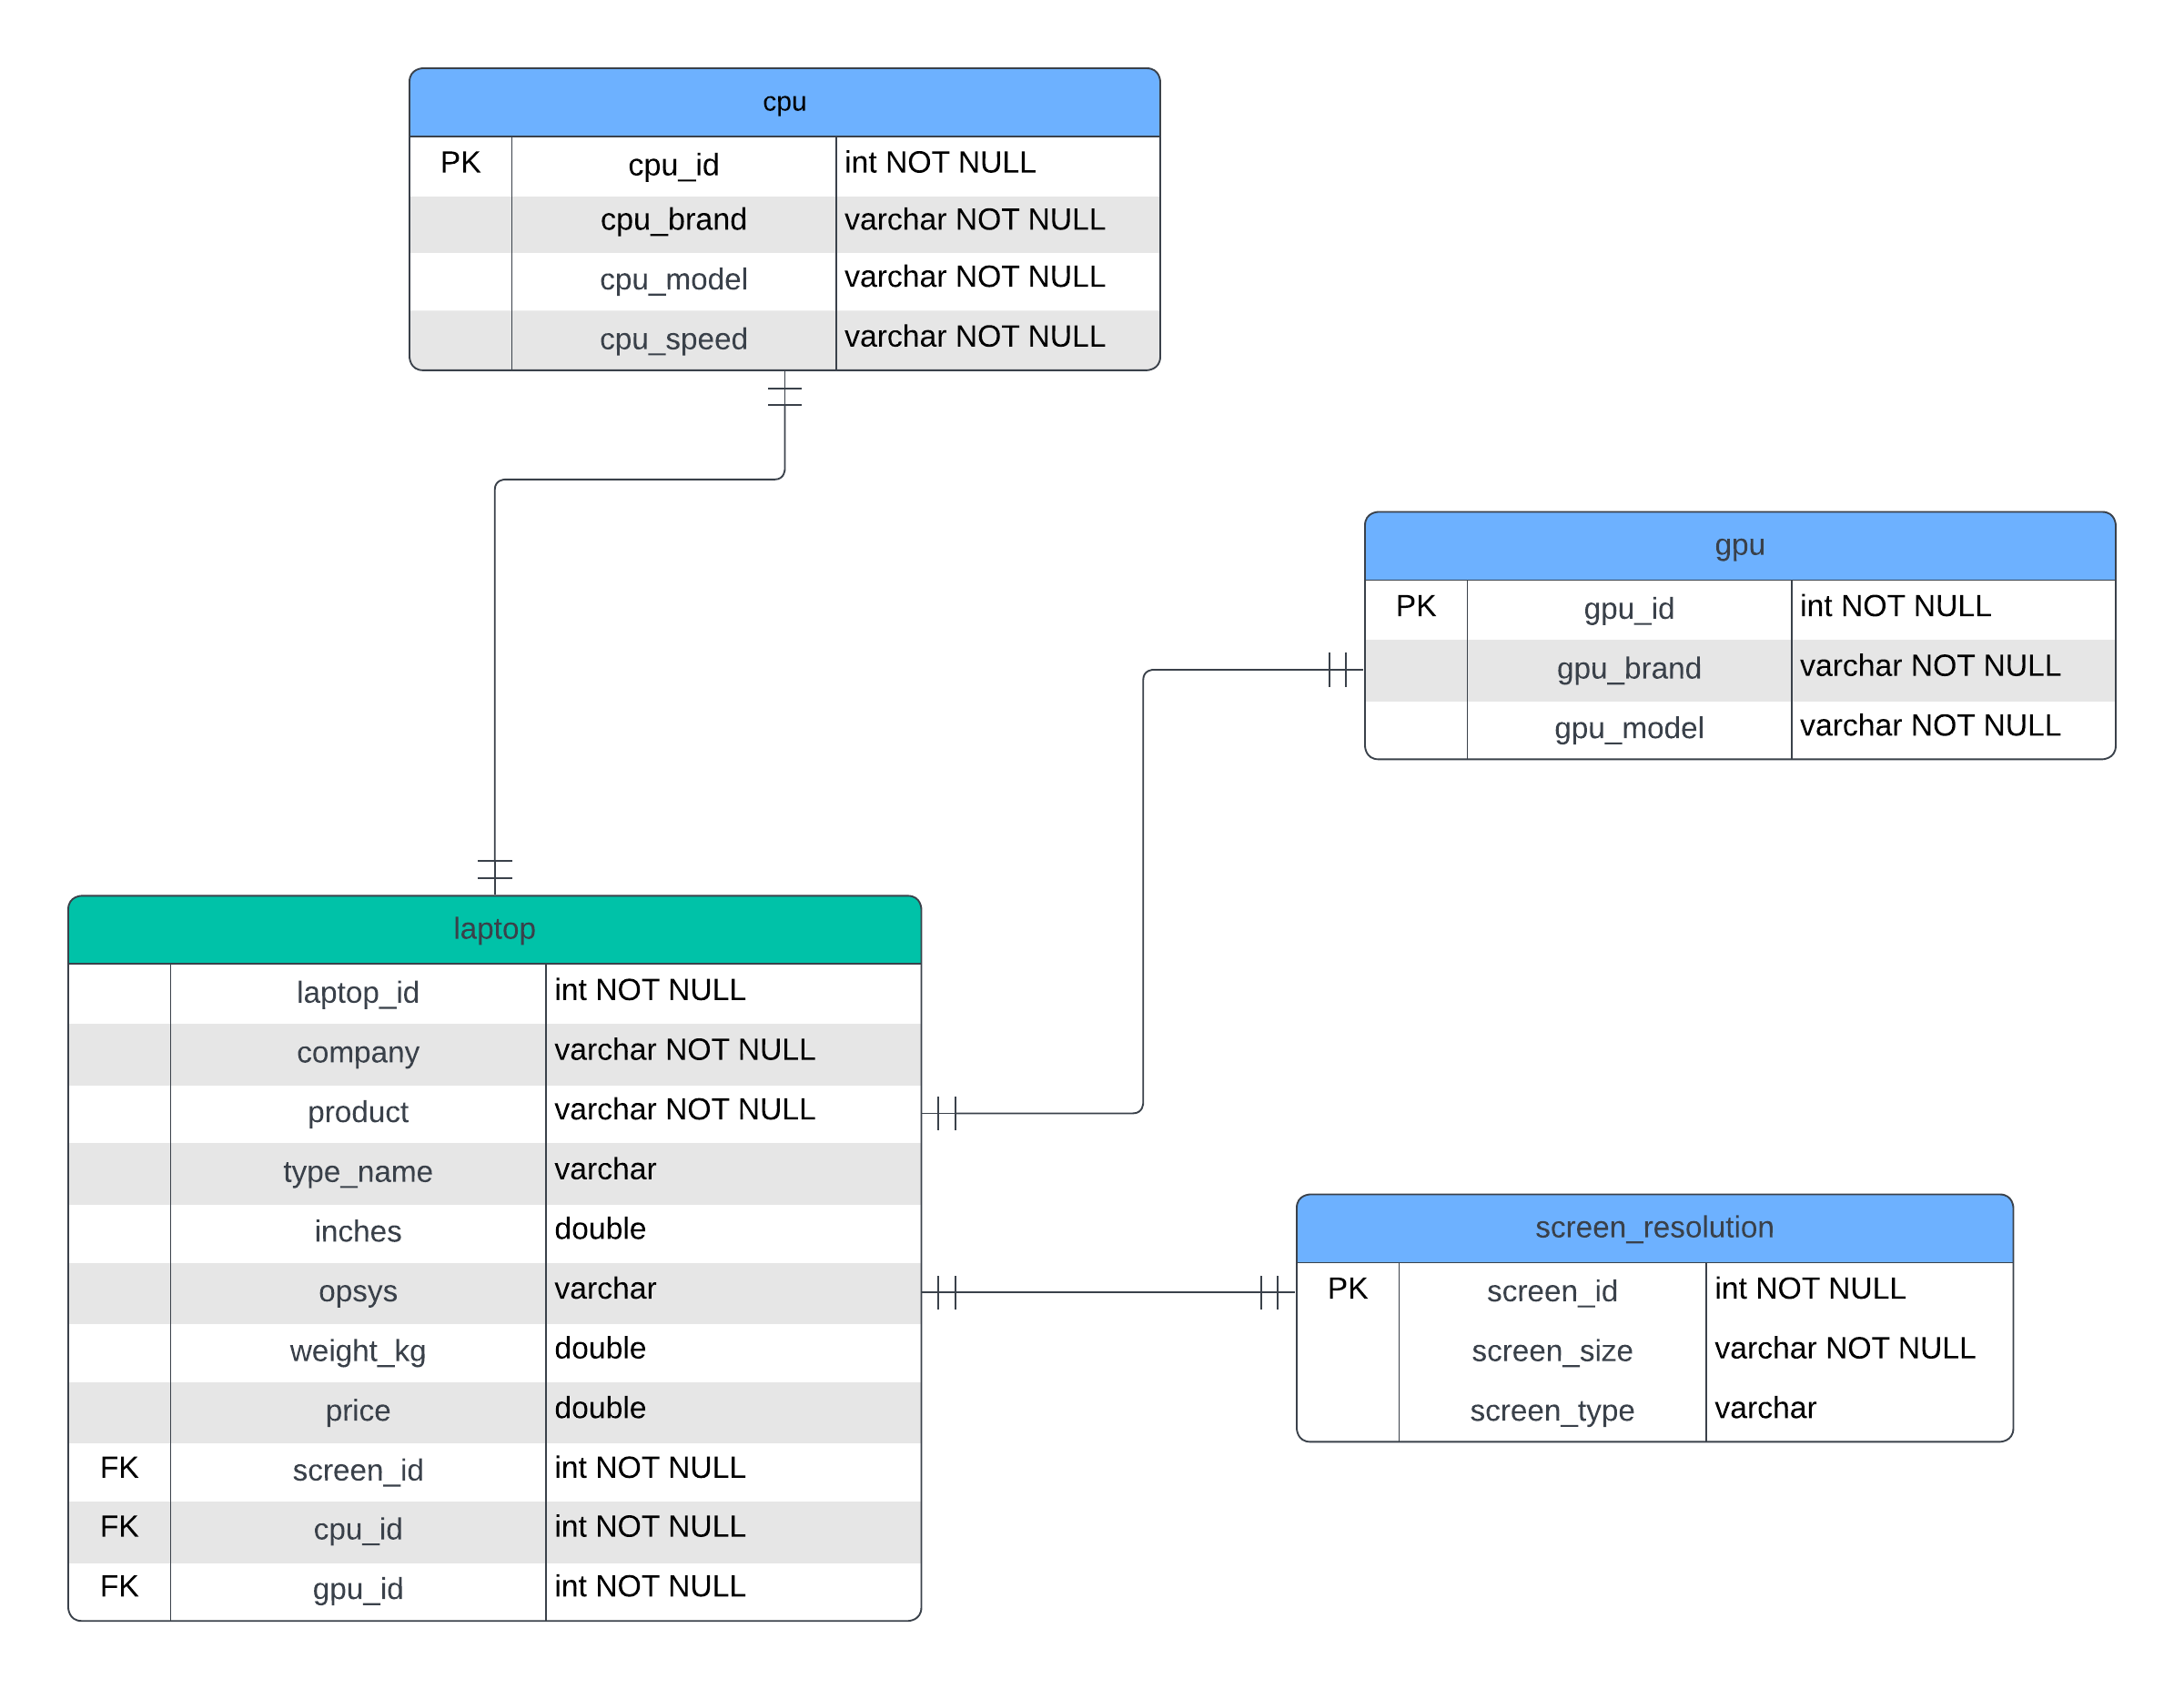

### Load CPU to DB

SQL script being executed:

```sql
INSERT INTO cpu (cpu_id, cpu_brand, cpu_model, cpu_speed)
VALUES (%(cpu_id)s, %(cpu_brand)s, %(cpu_model)s, %(cpu_speed)s)
ON CONFLICT (cpu_id)
DO UPDATE SET 
    cpu_brand = EXCLUDED.cpu_brand,
    cpu_model = EXCLUDED.cpu_model,
    cpu_speed = EXCLUDED.cpu_speed;


Join on laptops_sql schema

In [83]:
# Select distinct CPU information
cpu_df = laptops.select("CpuBrand", "CpuModel", "CpuSpeed").distinct()

# Define a window specification with partitioning by CpuBrand and ordering by CpuModel and CpuSpeed
window_spec = Window.partitionBy("CpuBrand").orderBy("CpuModel", "CpuSpeed")

# Add a new column with row numbers based on the window specification
cpu_df = cpu_df.withColumn("cpu_id", row_number().over(window_spec))

# Define the save directory
save_directory = "out/db_data/cpu"

# Save the DataFrame using the provided data loader utility
data_loader_util.save_with_timestamp(cpu_df, save_directory)

File saved as out/db_data/cpu/laptops_20240612135155.csv


In [84]:
cpu_df.printSchema()

root
 |-- CpuBrand: string (nullable = true)
 |-- CpuModel: string (nullable = true)
 |-- CpuSpeed: string (nullable = true)
 |-- cpu_id: integer (nullable = false)



In [85]:
import os

DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
JDBC_DRIVER_PATH = os.getenv('JDBC_DRIVER_PATH')

print(f"DB_HOST: {DB_HOST}")
print(f"DB_PORT: {DB_PORT}")
print(f"DB_NAME: {DB_NAME}")
print(f"DB_USER: {DB_USER}")
print(f"DB_PASSWORD: {DB_PASSWORD}")
print(f"JDBC_DRIVER_PATH: {JDBC_DRIVER_PATH}")


DB_HOST: pgdatabase
DB_PORT: 5432
DB_NAME: laptops
DB_USER: laptops_admin
DB_PASSWORD: laptops
JDBC_DRIVER_PATH: /usr/local/share/postgresql/postgresql-42.7.3.jar


In [86]:
import config

# Database connection details from config.py
host = config.DB_HOST
port = config.DB_PORT
dbname = config.DB_NAME
user = config.DB_USER
password = config.DB_PASSWORD

print(dbname)

laptops


In [87]:
from models import CPU, Base
import config

# Database connection details from config.py
host = config.DB_HOST
port = config.DB_PORT
dbname = config.DB_NAME
user = config.DB_USER
password = config.DB_PASSWORD

# Assuming cpu_df is already defined and loaded with data
# Rename columns to match the database schema first
cpu_df = cpu_df.withColumnRenamed("CpuBrand", "cpu_brand") \
               .withColumnRenamed("CpuModel", "cpu_model") \
               .withColumnRenamed("CpuSpeed", "cpu_speed")

# Generate unique cpu_id values
window_spec = Window.partitionBy("cpu_brand").orderBy("cpu_model", "cpu_speed")
cpu_df = cpu_df.withColumn("cpu_id", row_number().over(window_spec))

# Reorder columns to ensure cpu_id is the first column
cpu_df = cpu_df.select("cpu_id", "cpu_brand", "cpu_model", "cpu_speed")

# Define the JDBC URL
jdbc_url = f"jdbc:postgresql://{host}:{port}/{dbname}"
print(jdbc_url)
# Define connection properties
connection_properties = {
    'host': host,
    'port': port,
    'user': user,
    'password': password,
    'database': dbname
}

# Create the CPU table if it doesn't exist
data_loader_util.create_table_orm(host, port, dbname, user, password, 'cpu', Base)

# Upsert data into the CPU table
data_loader_util.upsert_data_to_db(cpu_df, connection_properties, "cpu", "cpu_id", ["cpu_brand", "cpu_model", "cpu_speed"])

jdbc:postgresql://pgdatabase:5432/laptops
Table 'cpu' already exists. Skipping creation.


### Load GPU to DB
SQL Upsert Script:

```sql
INSERT INTO gpu (gpu_id, gpu_brand, gpu_model, gpu_speed)
VALUES (%(gpu_id)s, %(gpu_brand)s, %(gpu_model)s, %(gpu_speed)s)
ON CONFLICT (gpu_id)
DO UPDATE SET 
    gpu_brand = EXCLUDED.gpu_brand,
    gpu_model = EXCLUDED.gpu_model,
    gpu_speed = EXCLUDED.gpu_speed;


In [88]:
# Select distinct GPU information
gpu_df = laptops.select("GpuBrand", "GpuModel").distinct()

# Define a window specification with partitioning by GpuBrand and ordering by GpuModel
window_spec = Window.partitionBy("GpuBrand").orderBy("GpuModel")

# Add a new column with row numbers based on the window specification
gpu_df = gpu_df.withColumn("gpu_id", row_number().over(window_spec))

# Define the save directory
save_directory = "out/db_data/gpu"

# Save the DataFrame using the provided data loader utility
data_loader_util.save_with_timestamp(gpu_df, save_directory)

File saved as out/db_data/gpu/laptops_20240612135158.csv


In [89]:
gpu_df.printSchema()

root
 |-- GpuBrand: string (nullable = true)
 |-- GpuModel: string (nullable = true)
 |-- gpu_id: integer (nullable = false)



Join on laptops_sql schema

In [90]:
from models import GPU, Base
import config

# Database connection details from config.py
host = config.DB_HOST
port = config.DB_PORT
dbname = config.DB_NAME
user = config.DB_USER
password = config.DB_PASSWORD


# Connection properties
connection_properties = {
    "host": host,
    "port": port,
    "user": user,
    "password": password,
    "database": dbname
}

# Select distinct GPU characteristics
gpu_df = laptops.select("GpuBrand", "GpuModel").distinct()

# Generate unique gpu_id values
window_spec = Window.partitionBy("GpuBrand").orderBy("GpuModel", "GpuBrand")
gpu_df = gpu_df.withColumn("gpu_id", row_number().over(window_spec))

# Rename columns to match the database schema
gpu_df = gpu_df.withColumnRenamed("GpuModel", "gpu_model") \
               .withColumnRenamed("GpuBrand", "gpu_brand")

# Connection properties
connection_properties = {
    "host": host,
    "port": port,
    "user": user,
    "password": password,
    "database": dbname
}

data_loader_util.create_table_orm(host, port, dbname, user, password, 'gpu', Base)
#test = TestUtil()

#test.upsert_data_to_db(gpu_df, connection_properties, "gpu", "gpu_id", ["gpu_brand", "gpu_model"])
# Save the DataFrame to the GPU table
data_loader_util.upsert_data_to_db(gpu_df, connection_properties, "gpu", "gpu_id", ["gpu_brand", "gpu_model"])

Table 'gpu' already exists. Skipping creation.


### Load Screen Resolution

SQL UPSERT:

```sql
INSERT INTO screen_resolution (screen_id, screen_size, screen_type)
VALUES (%(screen_id)s, %(screen_size)s, %(screen_type)s)
ON CONFLICT (screen_id)
DO UPDATE SET 
    screen_size = EXCLUDED.screen_size,
    screen_type = EXCLUDED.screen_type;


In [91]:
# Select distinct screen resolution characteristics
screen_resolution_df = laptops.select("DisplayType", "ScreenSize").distinct()

# Define a window specification with partitioning by DisplayType and ordering by ScreenSize
window_spec = Window.partitionBy("DisplayType").orderBy("ScreenSize")

# Generate a unique screen_id value for each row based on the window specification
screen_resolution_df = screen_resolution_df.withColumn("screen_id", row_number().over(window_spec))

# Define the save directory
save_directory = "out\db_data\screen_resolution"

# Save the DataFrame using the provided data loader utility
data_loader_util.save_with_timestamp(screen_resolution_df, save_directory)

File saved as out\db_data\screen_resolution/laptops_20240612135200.csv


Join on laptops_sql schema

In [92]:
screen_resolution_df.printSchema()

root
 |-- DisplayType: string (nullable = true)
 |-- ScreenSize: string (nullable = true)
 |-- screen_id: integer (nullable = false)



In [93]:
from models import ScreenResolution, Base
import config

# Database connection details from config.py
host = config.DB_HOST
port = config.DB_PORT
dbname = config.DB_NAME
user = config.DB_USER
password = config.DB_PASSWORD


# Connection properties
connection_properties = {
    "host": host,
    "port": port,
    "user": user,
    "password": password,
    "database": dbname
}

# Select distinct GPU characteristics
screen_resolution_df = laptops.select("DisplayType", "ScreenSize").distinct()


# Generate unique screen_id values with partitioning
window_spec = Window.partitionBy("DisplayType").orderBy("ScreenSize")
screen_resolution_df = screen_resolution_df.withColumn("screen_id", row_number().over(window_spec))

# Rename columns to match the database schema
screen_resolution_df =  screen_resolution_df \
                        .withColumnRenamed("DisplayType", "screen_type") \
                        .withColumnRenamed("ScreenSize", "screen_size")

# Connection properties
connection_properties = {
    "host": host,
    "port": port,
    "user": user,
    "password": password,
    "database": dbname
}

data_loader_util.create_table_orm(host, port, dbname, user, password, 'screen_resolution', Base)

data_loader_util.upsert_data_to_db(screen_resolution_df, connection_properties, "screen_resolution", "screen_id", ["screen_type", "screen_size"])

Table 'screen_resolution' already exists. Skipping creation.


### Load Laptops to DB

SQL Upsert:

```sql
INSERT INTO laptop (laptop_id, company, product, type_name, inches, opsys, weight_kg, price, cpu_id, gpu_id, screen_id)
VALUES (%(laptop_id)s, %(company)s, %(product)s, %(type_name)s, %(inches)s, %(opsys)s, %(weight_kg)s, %(price)s, %(cpu_id)s, %(gpu_id)s, %(screen_id)s)
ON CONFLICT (laptop_id)
DO UPDATE SET 
    company = EXCLUDED.company,
    product = EXCLUDED.product,
    type_name = EXCLUDED.type_name,
    inches = EXCLUDED.inches,
    opsys = EXCLUDED.opsys,
    weight_kg = EXCLUDED.weight_kg,
    price = EXCLUDED.price,
    cpu_id = EXCLUDED.cpu_id,
    gpu_id = EXCLUDED.gpu_id,
    screen_id = EXCLUDED.screen_id;


Creating the laptops_sql schema

In [94]:
# Rename columns in laptops DataFrame to match those in cpu_df, gpu_df, and screen_df
laptops_sql = laptops.withColumnRenamed("CpuBrand", "cpu_brand") \
                 .withColumnRenamed("CpuModel", "cpu_model") \
                 .withColumnRenamed("CpuSpeed", "cpu_speed") \
                 .withColumnRenamed("GpuBrand", "gpu_brand") \
                 .withColumnRenamed("GpuModel", "gpu_model") \
                 .withColumnRenamed("DisplayType", "screen_type") \
                 .withColumnRenamed("ScreenSize", "screen_size")

# Join laptops_sql with cpu_df to associate each laptop with the corresponding cpu_id
laptops_sql = laptops_sql.join(cpu_df, ["cpu_brand", "cpu_model", "cpu_speed"], "left")
# Drop the specified columns
columns_to_drop = ["cpu_brand", "cpu_model", "cpu_speed"]
laptops_sql = laptops_sql.drop(*columns_to_drop)

# Join laptops_sql with gpu_df to associate each laptop with the corresponding gpu_id
laptops_sql = laptops_sql.join(gpu_df, ["gpu_brand", "gpu_model"], "left")
# Drop the specified columns
columns_to_drop = ["gpu_brand", "gpu_model"]
laptops_sql = laptops_sql.drop(*columns_to_drop)

# Join laptops_sql with screen_df to associate each laptop with the corresponding screen_id
laptops_sql = laptops_sql.join(screen_resolution_df, ["screen_type", "screen_size"], "left")
# Drop the specified columns
columns_to_drop = ["screen_type", "screen_size"]
laptops_sql = laptops_sql.drop(*columns_to_drop)

# Show the schema to verify the updates
laptops_sql.printSchema()

root
 |-- laptop_ID: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- TypeName: string (nullable = true)
 |-- Inches: float (nullable = true)
 |-- Ram: string (nullable = true)
 |-- Memory: string (nullable = true)
 |-- OpSys: string (nullable = true)
 |-- Price_euros: float (nullable = true)
 |-- WeightKG: float (nullable = true)
 |-- cpu_id: integer (nullable = true)
 |-- gpu_id: integer (nullable = true)
 |-- screen_id: integer (nullable = true)



In [95]:
laptops_sql.show()

+---------+-------+------------------+---------+------+----+--------------------+----------+-----------+--------+------+------+---------+
|laptop_ID|Company|           Product| TypeName|Inches| Ram|              Memory|     OpSys|Price_euros|WeightKG|cpu_id|gpu_id|screen_id|
+---------+-------+------------------+---------+------+----+--------------------+----------+-----------+--------+------+------+---------+
|       18|  Apple|       MacBook Pro|Ultrabook|  15.4|16GB|           512GB SSD|     macOS|     2858.0|    1.83|    61|    12|        3|
|        3|     HP|            250 G6| Notebook|  15.6| 8GB|           256GB SSD|     No OS|      575.0|    1.86|    48|    15|        1|
|       11|     HP|            250 G6| Notebook|  15.6| 4GB|           500GB HDD|     No OS|      393.9|    1.86|    48|    15|        1|
|        7|  Apple|       MacBook Pro|Ultrabook|  15.4|16GB| 256GB Flash Storage|  Mac OS X|    2139.97|    2.04|    58|    22|        3|
|        5|  Apple|       MacBook 

In [96]:
from models import Laptop, Base
import config

# Database connection details from config.py
host = config.DB_HOST
port = config.DB_PORT
dbname = config.DB_NAME
user = config.DB_USER
password = config.DB_PASSWORD

# Connection properties
connection_properties = {
    "host": host,
    "port": port,
    "user": user,
    "password": password,
    "database": dbname
}


laptops_sql = laptops_sql.withColumnRenamed("Company", "company") \
                       .withColumnRenamed("Product", "product") \
                       .withColumnRenamed("TypeName", "type_name") \
                       .withColumnRenamed("Inches", "inches") \
                       .withColumnRenamed("OpSys", "opsys") \
                       .withColumnRenamed("Ram", "ram") \
                       .withColumnRenamed("Memory", "memory") \
                       .withColumnRenamed("WeightKG", "weight_kg") \
                       .withColumnRenamed("Price_euros", "price")


columns_to_insert = [
    "company", "product", "type_name", "inches", "opsys","ram","memory",
    "weight_kg", "price", "cpu_id", "gpu_id", "screen_id"
]

data_loader_util.create_table_orm(host, port, dbname, user, password, 'laptop', Base)

data_loader_util.upsert_data_to_db(laptops_sql, connection_properties, "laptop", "laptop_ID", columns_to_insert)

Table 'laptop' already exists. Skipping creation.


Save the laptops table to a .csv

In [97]:
# Save the DataFrame to the specified directory
save_directory = "out\db_data\laptops"
data_loader_util.save_with_timestamp(laptops_sql, save_directory)

File saved as out\db_data\laptops/laptops_20240612135211.csv


Finally stop the spark session

In [98]:
spark.stop()

## ETL Recap so far

To summarize what we did: 

1. Extracted the data from the `laptops.csv` and put into a DataFrame
2. Use Data Cleaning methods that we have proven to be effective.
3. Transform the Data by Atomizing the `laptops.csv` into three new DataFrames; `CPU`, `GPU`, `ScreenType`
4. Load data to a Postgres Database

This is the ETL Diagram:

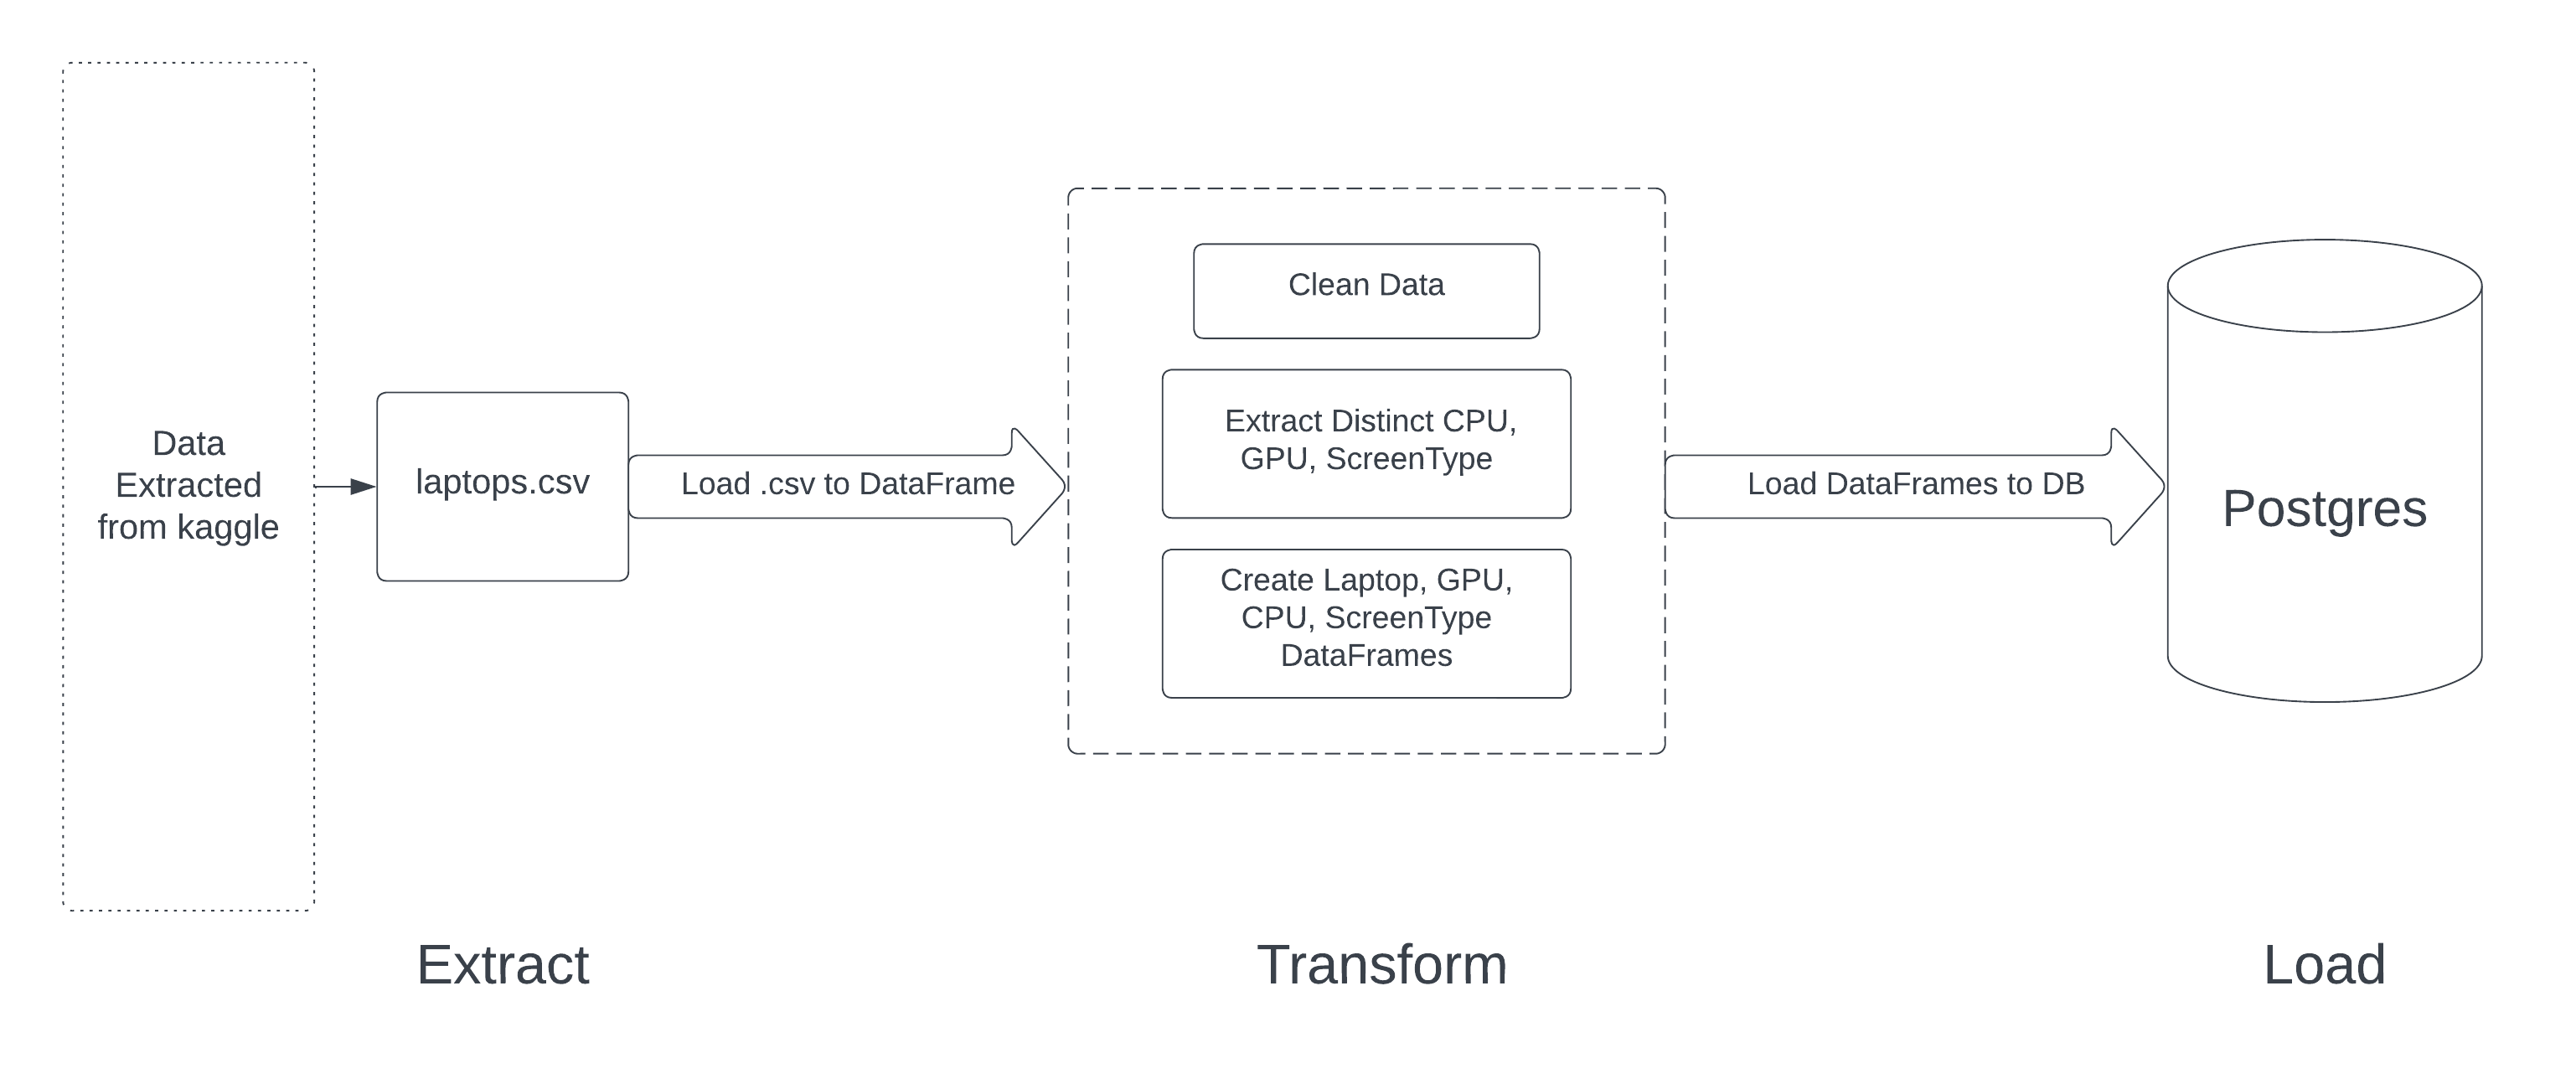

# Analysis using SQL Window Function

In this section, we will find some insights in the laptops data using SQL Window Function

#### Creating the Connection Properties and SQL Engine

In [99]:
# Database connection details from config.py
host = config.DB_HOST
port = config.DB_PORT
dbname = config.DB_NAME
user = config.DB_USER
password = config.DB_PASSWORD

# Connection properties
connection_properties = {
    "host": host,
    "port": port,
    "user": user,
    "password": password,
    "database": dbname
}

# Create connection string
conn_str = f"postgresql+psycopg2://{connection_properties['user']}:{connection_properties['password']}@{connection_properties['host']}:{connection_properties['port']}/{connection_properties['database']}"

# Create SQLAlchemy engine
analysis_sql_engine = create_engine(conn_str)


### Most and Least Expensive Laptop Analysis

#### Average Laptop Price by Company

In [100]:
# Define SQL query
query_avg_price_by_company = """
SELECT company,
       AVG(price) as avg_price_by_company
FROM   laptop
GROUP  BY company
ORDER  BY avg_price_by_company DESC;
"""


resulft_df = pd.read_sql(query_avg_price_by_company, analysis_sql_engine)

resulft_df.head(10)

,company,avg_price_by_company
0,Razer,3346.142857
1,LG,2099.000000
2,MSI,1728.908148
3,Google,1677.666667
4,Microsoft,1612.308333
5,Apple,1564.198571
6,Huawei,1424.000000
7,Samsung,1413.444444
8,Toshiba,1267.812500
9,Dell,1204.515483


#### Detailed Information about the Most Expensive Laptop Brand

We have used `JOIN` from the three different table to get the most expensive laptop with complete detail.

In [101]:
# Define SQL query
query_expensive_detailed_laptop = """
SELECT l.laptop_id,
       l.company,
       l.product,
       l.type_name,
       l.inches,
       l.opsys,
       l.ram,
       l.memory,
       l.weight_kg,
       l.price,
       c.cpu_brand,
       c.cpu_model,
       c.cpu_speed,
       g.gpu_brand,
       g.gpu_model,
       s.screen_size,
       s.screen_type
FROM   laptop l
JOIN   cpu c ON l.cpu_id = c.cpu_id
JOIN   gpu g ON l.gpu_id = g.gpu_id
JOIN   screen_resolution s ON l.screen_id = s.screen_id
ORDER  BY l.price DESC
LIMIT  10;
"""

# Execute query and load data into DataFrame
result_df = pd.read_sql(query_expensive_detailed_laptop, analysis_sql_engine)

result_df.head(10)

,laptop_id,company,product,type_name,inches,opsys,ram,memory,weight_kg,price,cpu_brand,cpu_model,cpu_speed,gpu_brand,gpu_model,screen_size,screen_type
0,200,Razer,Blade Pro,Gaming,17.3,Windows 10,32GB,1TB SSD,3.49,6099.0,Intel,Core i7 7820HK,2.9GHz,Nvidia,GeForce GTX 1080,1366x768,Unknown
1,839,Razer,Blade Pro,Gaming,17.3,Windows 10,32GB,512GB SSD,3.49,5499.0,Intel,Core i7 7820HK,2.9GHz,Nvidia,GeForce GTX 1080,1366x768,Unknown
2,617,Lenovo,Thinkpad P51,Notebook,15.6,Windows 10,32GB,1TB SSD,2.50,4899.0,Intel,Xeon E3-1535M v6,3.1GHz,Nvidia,Quadro M2200M,1366x768,Unknown
3,758,HP,Zbook 17,Workstation,17.3,Windows 7,16GB,256GB SSD,3.00,4389.0,Intel,Xeon E3-1535M v5,2.9GHz,Nvidia,Quadro M2000M,1440x900,Unknown
4,1081,Asus,ROG G701VO,Gaming,17.3,Windows 10,64GB,1TB SSD,3.58,3975.0,Intel,Core i7 6820HK,2.7GHz,Nvidia,GeForce GTX 980,1440x900,Unknown
5,1151,HP,ZBook 17,Workstation,17.3,Windows 7,8GB,256GB SSD,3.00,3949.4,Intel,Core i7 6700HQ,2.6GHz,Nvidia,Quadro M3000M,1440x900,Unknown
6,243,Asus,ROG G703VI-E5062T,Gaming,17.3,Windows 10,32GB,512GB SSD + 1TB HDD,4.70,3890.0,Intel,Core i7 7820HK,2.9GHz,Nvidia,GeForce GTX 1080,1366x768,Unknown
7,731,Dell,Alienware 17,Gaming,17.3,Windows 10,32GB,1TB SSD + 1TB HDD,4.36,3659.4,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX 1070,1366x768,Unknown
8,789,Dell,Alienware 17,Gaming,17.3,Windows 10,32GB,1TB SSD + 1TB HDD,4.42,3588.8,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX 1070M,1440x900,Unknown
9,1249,Razer,Blade Pro,Gaming,14.0,Windows 10,16GB,1TB SSD,1.95,3499.0,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX 1060,1366x768,Unknown


#### Detailed Information about the Least Expensive Laptop Brand

Similar to the above query, we will get the least expensive Laptop Brand

In [102]:
# Define SQL query
query_least_expensive_detailed_laptop = """
SELECT l.laptop_id,
       l.company,
       l.product,
       l.type_name,
       l.inches,
       l.opsys,
       l.weight_kg,
       l.ram,
       l.memory,
       l.price,
       c.cpu_brand,
       c.cpu_model,
       c.cpu_speed,
       g.gpu_brand,
       g.gpu_model,
       s.screen_size,
       s.screen_type
FROM   laptop l
JOIN   cpu c ON l.cpu_id = c.cpu_id
JOIN   gpu g ON l.gpu_id = g.gpu_id
JOIN   screen_resolution s ON l.screen_id = s.screen_id
ORDER  BY l.price ASC
LIMIT  10;
"""

# Execute query and load data into DataFrame
result_df = pd.read_sql(query_least_expensive_detailed_laptop, analysis_sql_engine)

result_df.head(10)

,laptop_id,company,product,type_name,inches,opsys,weight_kg,ram,memory,price,cpu_brand,cpu_model,cpu_speed,gpu_brand,gpu_model,screen_size,screen_type
0,1135,Vero,V131 (X5-Z8350/4GB/32GB/FHD/W10),Notebook,13.3,Windows 10,1.35,4GB,32GB Flash Storage,196.00,Samsung,Cortex A72&A53,2.0GHz,Nvidia,GeForce 920,1366x768,Unknown
1,800,Vero,K146 (N3350/4GB/32GB/W10),Notebook,14.0,Windows 10,1.22,4GB,32GB Flash Storage,202.90,Intel,Celeron Dual Core N3350,1.1GHz,Nvidia,GeForce 920MX,1920x1080,Unknown
2,1117,Acer,Chromebook 15,Notebook,15.6,Chrome OS,2.20,4GB,16GB SSD,209.00,Intel,Celeron Dual Core 3205U,1.5GHz,Nvidia,GeForce 150MX,1366x768,Unknown
3,562,Asus,A541NA-GO342 (N3350/4GB/500GB/Linux),Notebook,15.6,Linux,2.00,4GB,500GB HDD,224.00,Intel,Celeron Dual Core N3350,1.1GHz,Nvidia,GeForce 920MX,1366x768,Unknown
4,69,HP,Stream 14-AX040wm,Notebook,14.0,Windows 10,1.44,4GB,32GB SSD,229.00,Intel,Celeron Dual Core N3060,1.6GHz,Nvidia,GeForce 920,1366x768,Unknown
5,31,Chuwi,"LapBook 15.6""""",Notebook,15.6,Windows 10,1.89,4GB,64GB Flash Storage,244.99,Intel,Atom x5-Z8300,1.44GHz,Nvidia,GeForce 150MX,1366x768,Unknown
6,490,Chuwi,"Lapbook 15,6",Notebook,15.6,Windows 10,1.89,4GB,64GB Flash Storage,248.90,Intel,Atom x5-Z8350,1.44GHz,Nvidia,GeForce 150MX,1366x768,Unknown
7,36,Lenovo,IdeaPad 120S-14IAP,Notebook,14.0,Windows 10,1.44,4GB,64GB Flash Storage,249.00,Intel,Celeron Dual Core N3350,1.1GHz,Nvidia,GeForce 920MX,1366x768,Unknown
8,582,Mediacom,SmartBook 141,Notebook,14.0,Windows 10,1.40,4GB,32GB SSD,249.00,Intel,Atom x5-Z8350,1.44GHz,Nvidia,GeForce 150MX,1366x768,Unknown
9,139,Lenovo,V110-15IAP (N3350/4GB/1TB/No,Notebook,15.6,No OS,1.90,4GB,1TB HDD,252.36,Intel,Celeron Dual Core N3350,1.1GHz,Nvidia,GeForce 920MX,1366x768,Unknown


#### Ranking Laptops by Price Within Each Company

We use the `RANK()` function to assign a unique rank to each laptop based on its price, starting from 1 for the highest price. The `OVER (PARTITION BY company ORDER BY price DESC)` clause divides the dataset into partitions for each company and orders the laptops within each company by price in descending order. This allows us to see the relative ranking of laptops by price within each company, with the highest-priced laptop getting rank 1.

With this query, we can sample some laptop brands and find the most expensive and least expensive laptop brand per Company.


In [103]:
# Define SQL query
query = """
SELECT l.laptop_id,
       l.company,
       l.product,
       l.price,
       l.type_name,
       l.inches,
       l.ram,
       l.memory,
       l.opsys,
       l.weight_kg,
       s.screen_type,
       s.screen_size,
       c.cpu_brand,
       c.cpu_model,
       c.cpu_speed,
       g.gpu_brand,
       g.gpu_model,
       RANK() OVER (PARTITION BY l.company ORDER BY l.price DESC) as price_rank
FROM   laptop l
JOIN   screen_resolution s ON l.screen_id = s.screen_id
JOIN   cpu c ON l.cpu_id = c.cpu_id
JOIN   gpu g ON l.gpu_id = g.gpu_id
ORDER  BY l.company, price_rank ASC;
"""

# Execute query and load data into DataFrame
result_df = pd.read_sql(query, analysis_sql_engine)

##### `Acer` Prices Rank

In [104]:
filtered_acer_df = result_df[result_df['company'] == 'Acer']
filtered_acer_df.head(10)

,laptop_id,company,product,price,type_name,inches,ram,memory,opsys,weight_kg,screen_type,screen_size,cpu_brand,cpu_model,cpu_speed,gpu_brand,gpu_model,price_rank
0,1207,Acer,Predator G9-793,2599.0,Gaming,17.3,16GB,256GB SSD + 1TB HDD,Windows 10,4.20,Unknown,1440x900,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX 1070,1
1,797,Acer,Predator G9-793,2299.0,Gaming,17.3,16GB,256GB SSD + 1TB HDD,Windows 10,4.20,Unknown,1440x900,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX 1060,2
2,738,Acer,Predator 17,1935.0,Gaming,17.3,16GB,128GB SSD + 1TB HDD,Windows 10,4.20,Unknown,1440x900,Intel,Core i7 6700HQ,2.6GHz,Nvidia,GeForce GTX 1060,3
3,687,Acer,Aspire VX5-591G,1299.0,Gaming,15.6,16GB,256GB SSD,Windows 10,2.50,Unknown,1366x768,Intel,Core i5 7300HQ,2.5GHz,Nvidia,GeForce GTX 1050 Ti,4
4,1014,Acer,Nitro 5,1260.0,Gaming,15.6,8GB,128GB SSD + 1TB HDD,Windows 10,2.70,Unknown,1440x900,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX 1050,5
5,1237,Acer,SP714-51 (i7-7Y75/8GB/256GB/FHD/W10),1149.0,2 in 1 Convertible,14.0,8GB,256GB SSD,Windows 10,1.20,Unknown,1366x768,Intel,Core i7 7Y75,1.3GHz,Nvidia,GeForce GTX 1050,6
6,976,Acer,Aspire F5-573G-510L,1009.0,Notebook,15.6,12GB,128GB SSD + 1TB HDD,Windows 10,2.40,Unknown,1366x768,Intel,Core i5 7200U,2.5GHz,Nvidia,GeForce GTX 950M,7
7,714,Acer,Spin 5,999.0,2 in 1 Convertible,13.3,8GB,256GB SSD,Windows 10,1.60,Unknown,1366x768,Intel,Core i5 8250U,1.6GHz,Nvidia,GeForce GTX 940MX,8
8,192,Acer,Swift 7,989.0,Ultrabook,13.3,8GB,256GB SSD,Windows 10,1.12,Unknown,1440x900,Intel,Core i5 7Y54,1.2GHz,Nvidia,GeForce GTX 1050,9
9,301,Acer,Aspire A715-71G,979.0,Notebook,15.6,8GB,256GB SSD,Linux,2.50,Unknown,1366x768,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX 1050 Ti,10


##### `Lenovo` Prices Rank

In [105]:
filtered_lenovo_df = result_df[result_df['company'] == 'Lenovo']
filtered_lenovo_df.head(10)

,laptop_id,company,product,price,type_name,inches,ram,memory,opsys,weight_kg,screen_type,screen_size,cpu_brand,cpu_model,cpu_speed,gpu_brand,gpu_model,price_rank
821,617,Lenovo,Thinkpad P51,4899.00,Notebook,15.6,32GB,1TB SSD,Windows 10,2.50,Unknown,1366x768,Intel,Xeon E3-1535M v6,3.1GHz,Nvidia,Quadro M2200M,1
822,752,Lenovo,Thinkpad P51s,3299.00,Workstation,15.6,16GB,1TB SSD,Windows 10,2.50,Unknown,1366x768,Intel,Core i7 7600U,2.8GHz,Nvidia,Quadro M520M,2
823,1096,Lenovo,IdeaPad Y900-17ISK,3240.00,Gaming,17.3,32GB,512GB SSD + 1.0TB Hybrid,Windows 10,4.60,Unknown,1440x900,Intel,Core i7 6820HK,2.7GHz,Nvidia,GeForce GTX 980M,3
824,570,Lenovo,Thinkpad P71,2999.00,Notebook,17.3,8GB,256GB SSD,Windows 10,3.40,Unknown,1440x900,Intel,Core i7 7700HQ,2.8GHz,Nvidia,Quadro M620M,4
825,1031,Lenovo,ThinkPad P70,2968.00,Notebook,17.3,16GB,512GB SSD,Windows 7,2.40,Unknown,1366x768,Intel,Core i7 6820HQ,2.7GHz,Nvidia,Quadro 3000M,5
826,194,Lenovo,Thinkpad Yoga,2824.00,2 in 1 Convertible,14.0,16GB,1TB SSD,Windows 10,1.42,Unknown,1920x1080,Intel,Core i7 7500U,2.7GHz,Nvidia,GeForce GTX 1050 Ti,6
827,1131,Lenovo,IdeaPad Y900-17ISK,2749.99,Gaming,17.3,16GB,256GB SSD + 1.0TB Hybrid,Windows 10,4.60,Unknown,1440x900,Intel,Core i7 6820HK,2.7GHz,Nvidia,GeForce GTX 980M,7
828,584,Lenovo,IdeaPad Y910-17ISK,2663.00,Gaming,17.3,32GB,256GB SSD + 1TB HDD,Windows 10,4.60,Unknown,1440x900,Intel,Core i7 6820HK,2.7GHz,Nvidia,GeForce GTX 1070,8
829,406,Lenovo,Thinkpad X1,2625.00,Ultrabook,14.0,16GB,1TB SSD,Windows 10,1.13,Unknown,1440x900,Intel,Core i7 7500U,2.7GHz,Nvidia,GeForce GTX 1050 Ti,9
830,1064,Lenovo,ThinkPad X1,2620.00,Notebook,14.0,16GB,256GB SSD,Windows 7,1.10,Unknown,1440x900,Intel,Core i7 6600U,2.6GHz,Nvidia,GeForce 930MX,10


##### `HP` Prices Rank

In [106]:
filtered_hp_df = result_df[result_df['company'] == 'HP']
filtered_hp_df.head(10)

,laptop_id,company,product,price,type_name,inches,ram,memory,opsys,weight_kg,screen_type,screen_size,cpu_brand,cpu_model,cpu_speed,gpu_brand,gpu_model,price_rank
568,758,HP,Zbook 17,4389.00,Workstation,17.3,16GB,256GB SSD,Windows 7,3.00,Unknown,1440x900,Intel,Xeon E3-1535M v5,2.9GHz,Nvidia,Quadro M2000M,1
569,1151,HP,ZBook 17,3949.40,Workstation,17.3,8GB,256GB SSD,Windows 7,3.00,Unknown,1440x900,Intel,Core i7 6700HQ,2.6GHz,Nvidia,Quadro M3000M,2
570,924,HP,Elitebook Folio,3100.00,Ultrabook,12.5,8GB,240GB SSD,Windows 10,1.09,Unknown,1366x768,Intel,Core M 6Y75,1.2GHz,Nvidia,GeForce 930MX,3
571,1118,HP,ZBook 17,2899.00,Workstation,17.3,8GB,1TB HDD,Windows 7,3.00,Unknown,1440x900,Intel,Core i7 6700HQ,2.6GHz,Nvidia,GeForce 920M,4
572,868,HP,EliteBook x360,2559.00,2 in 1 Convertible,13.3,8GB,256GB SSD,Windows 10,1.28,Unknown,1366x768,Intel,Core i7 7600U,2.8GHz,Nvidia,GeForce GTX 1050 Ti,5
573,321,HP,Spectre x360,2449.00,2 in 1 Convertible,13.3,16GB,1TB SSD,Windows 10,1.29,Unknown,1366x768,Intel,Core i7 8550U,1.8GHz,Nvidia,GeForce GTX 940MX,6
574,744,HP,ZBook 15,2419.00,Workstation,15.6,16GB,256GB SSD,Windows 10,2.60,Unknown,1366x768,Intel,Core i7 7700HQ,2.8GHz,Nvidia,Quadro M2200,7
575,1164,HP,EliteBook 820,2296.95,Ultrabook,12.5,8GB,256GB SSD,Windows 7,1.26,Unknown,1366x768,Intel,Core i7 6500U,2.50GHz,Nvidia,GeForce 930MX,8
576,858,HP,EliteBook x360,2277.00,2 in 1 Convertible,13.3,8GB,256GB SSD,Windows 10,1.28,Unknown,1366x768,Intel,Core i5 7200U,2.5GHz,Nvidia,GeForce GTX 1050 Ti,9
577,964,HP,ZBook Studio,2249.00,Workstation,15.6,8GB,8GB SSD,Windows 10,2.00,Unknown,1440x900,Intel,Core i7 6820HQ,2.7GHz,Nvidia,Quadro M1000M,10


##### `Asus` Prices Rank

In [107]:
filtered_asus_df = result_df[result_df['company'] == 'Asus']
filtered_asus_df.head(10)

,laptop_id,company,product,price,type_name,inches,ram,memory,opsys,weight_kg,screen_type,screen_size,cpu_brand,cpu_model,cpu_speed,gpu_brand,gpu_model,price_rank
118,1081,Asus,ROG G701VO,3975.0,Gaming,17.3,64GB,1TB SSD,Windows 10,3.58,Unknown,1440x900,Intel,Core i7 6820HK,2.7GHz,Nvidia,GeForce GTX 980,1
119,243,Asus,ROG G703VI-E5062T,3890.0,Gaming,17.3,32GB,512GB SSD + 1TB HDD,Windows 10,4.70,Unknown,1366x768,Intel,Core i7 7820HK,2.9GHz,Nvidia,GeForce GTX 1080,2
120,252,Asus,Rog G701VIK-BA060T,2999.0,Gaming,17.3,16GB,256GB SSD,Windows 10,3.60,Unknown,1366x768,Intel,Core i7 7820HK,2.9GHz,Nvidia,GeForce GTX 1080,3
121,524,Asus,ROG Zephyrus,2968.0,Gaming,15.6,24GB,512GB SSD,Windows 10,2.24,Unknown,1366x768,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX1080,4
122,658,Asus,ROG G701VI,2799.0,Gaming,17.3,32GB,512GB SSD,Windows 10,3.80,Unknown,1440x900,Intel,Core i7 6820HK,2.7GHz,Nvidia,GeForce GTX 1080,5
123,1227,Asus,Rog Strix,2449.0,Gaming,15.6,16GB,256GB SSD + 1TB HDD,Windows 10,2.20,Unknown,1366x768,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX 1070,6
124,845,Asus,Rog GL702VS-BA023T,2419.0,Gaming,17.3,16GB,256GB SSD + 1TB HDD,Windows 10,2.90,Unknown,1366x768,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX 1070,7
125,790,Asus,Rog G752VS-BA171T,2350.0,Gaming,17.3,16GB,256GB SSD + 1TB HDD,Windows 10,4.30,Unknown,1440x900,Intel,Core i7 6700HQ,2.6GHz,Nvidia,GeForce GTX 1070,8
126,1265,Asus,Rog GL502VS,2325.0,Gaming,15.6,16GB,256GB SSD + 1TB HDD,Windows 10,2.34,Unknown,1440x900,Intel,Core i7 6700HQ,2.6GHz,Nvidia,GeForce GTX 1070,9
127,1114,Asus,G752VY-GC162T (i7-6700HQ/16GB/1TB,2299.0,Gaming,17.3,16GB,128GB SSD + 1TB HDD,Windows 10,4.30,Unknown,1440x900,Intel,Core i7 6700HQ,2.6GHz,Nvidia,GeForce GTX 980M,10


##### `Vero` Prices Rank

In [108]:
filtered_vero_df = result_df[result_df['company'] == 'Vero']
filtered_vero_df.head(10)

,laptop_id,company,product,price,type_name,inches,ram,memory,opsys,weight_kg,screen_type,screen_size,cpu_brand,cpu_model,cpu_speed,gpu_brand,gpu_model,price_rank
1233,195,Vero,K147 (N3350/4GB/32GB/FHD/W10),260.0,Notebook,14.0,4GB,32GB Flash Storage,Windows 10,1.30,Unknown,1440x900,Intel,Celeron Dual Core N3350,1.1GHz,Nvidia,GeForce 920MX,1
1234,800,Vero,K146 (N3350/4GB/32GB/W10),202.9,Notebook,14.0,4GB,32GB Flash Storage,Windows 10,1.22,Unknown,1920x1080,Intel,Celeron Dual Core N3350,1.1GHz,Nvidia,GeForce 920MX,2
1235,1135,Vero,V131 (X5-Z8350/4GB/32GB/FHD/W10),196.0,Notebook,13.3,4GB,32GB Flash Storage,Windows 10,1.35,Unknown,1366x768,Samsung,Cortex A72&A53,2.0GHz,Nvidia,GeForce 920,3


##### Querying the top 1's of Price Rank of each Comapny

In [109]:
# Filter the DataFrame to include only rows where price_rank is 1
top_laptops_df = result_df[result_df['price_rank'] == 1]
top_laptops_df = top_laptops_df.sort_values(by='price', ascending=False)

top_laptops_df.head(15)

,laptop_id,company,product,price,type_name,inches,ram,memory,opsys,weight_kg,screen_type,screen_size,cpu_brand,cpu_model,cpu_speed,gpu_brand,gpu_model,price_rank
1169,200,Razer,Blade Pro,6099.00,Gaming,17.3,32GB,1TB SSD,Windows 10,3.49,Unknown,1366x768,Intel,Core i7 7820HK,2.9GHz,Nvidia,GeForce GTX 1080,1
821,617,Lenovo,Thinkpad P51,4899.00,Notebook,15.6,32GB,1TB SSD,Windows 10,2.50,Unknown,1366x768,Intel,Xeon E3-1535M v6,3.1GHz,Nvidia,Quadro M2200M,1
568,758,HP,Zbook 17,4389.00,Workstation,17.3,16GB,256GB SSD,Windows 7,3.00,Unknown,1440x900,Intel,Xeon E3-1535M v5,2.9GHz,Nvidia,Quadro M2000M,1
118,1081,Asus,ROG G701VO,3975.00,Gaming,17.3,64GB,1TB SSD,Windows 10,3.58,Unknown,1440x900,Intel,Core i7 6820HK,2.7GHz,Nvidia,GeForce GTX 980,1
272,731,Dell,Alienware 17,3659.40,Gaming,17.3,32GB,1TB SSD + 1TB HDD,Windows 10,4.36,Unknown,1366x768,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX 1070,1
97,18,Apple,MacBook Pro,2858.00,Ultrabook,15.4,16GB,512GB SSD,macOS,1.83,Unknown,1600x900,Intel,Core i7,2.9GHz,Nvidia,GeForce 960M,1
1185,498,Toshiba,Portege X30-D-10L,2799.00,Ultrabook,13.3,32GB,512GB SSD,Windows 10,1.05,Unknown,1366x768,Intel,Core i7 7500U,2.7GHz,Nvidia,GeForce GTX 1050 Ti,1
1115,181,MSI,GT80S 6QF-074US,2799.00,Gaming,18.4,32GB,512GB SSD + 1TB HDD,Windows 10,4.40,Unknown,1366x768,Intel,Core i7 6920HQ,2.9GHz,Nvidia,GTX 980 SLI,1
0,1207,Acer,Predator G9-793,2599.00,Gaming,17.3,16GB,256GB SSD + 1TB HDD,Windows 10,4.20,Unknown,1440x900,Intel,Core i7 7700HQ,2.8GHz,Nvidia,GeForce GTX 1070,1
1109,456,Microsoft,Surface Laptop,2589.00,Ultrabook,13.5,16GB,512GB SSD,Windows 10 S,1.25,Unknown,1440x900,Intel,Core i7 7660U,2.5GHz,Nvidia,GeForce GTX 1070M,1


#### Final Insights on `Price` Rank

The most expensive laptop of each brand are mostly `Ultrabooks` and `Gaming`. For further analysis, we can create another scope for laptop type analysis.

### Average Laptop Price by Laptop Type

We will find the average laptop per distinct type name in the laptops table. Looking at the result of the query. It looks like `Workstation` laptops are more expensive, followed by `Gaming` and `Ultrabook` types. 

In [110]:
# Define SQL query for calculating average price by laptop type
query_avg_price_by_type = """
SELECT DISTINCT type_name,
       AVG(price) OVER (PARTITION BY type_name) as avg_price_by_type
FROM   laptop
ORDER  BY avg_price_by_type DESC;
"""
# Execute query and load data into DataFrame
avg_price_by_type_df = pd.read_sql(query_avg_price_by_type, analysis_sql_engine)
avg_price_by_type_df.head(10)

,type_name,avg_price_by_type
0,Workstation,2280.358966
1,Gaming,1731.380634
2,Ultrabook,1551.908462
3,2 in 1 Convertible,1296.273866
4,Notebook,803.468737
5,Netbook,771.994737



---

# Summary

We have reached the end of this notebook. Throughout this project, we have utilized a variety of tools, algorithms, and concepts to achieve our objectives:

1. **Binary Search Algorithm**: Efficiently searched for specific values within the dataset.
2. **Matplotlib**: Visualized time complexity to better understand algorithm performance.
3. **Data Cleaning and Prototyping**: Applied techniques such as chunking and parallelization to enhance performance.
4. **PySpark**: Transformed and processed large datasets efficiently.
5. **PostgreSQL**: Loaded and managed data in a relational database.
6. **SQL Window Functions**: Extracted valuable insights from the laptops table through advanced SQL queries.

While this project has covered a significant amount of ground, there are still areas for further improvement. Future enhancements cite dependencies.
- **Machine Learning**: Leveraging machine learning algorithms or models to gain deeper insights from the data.

Thank you for following along with this notebook. If you have any suggestions or comments, please feel free to create an issue on the GitHub reposi/suggestionstory. Yoly appreciated!ons of the project.